In [26]:
# Set up
%pylab inline

# Allow us to edit fonts in Illustrator
import matplotlib
matplotlib.rcParams['ps.useafm'] = True
matplotlib.rcParams['pdf.use14corefonts'] = True
matplotlib.rcParams['text.usetex'] = True

# Libraries
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scipy.stats
import seaborn.apionly as sns


# Examples - top causal 
causal = pd.read_csv("/storage/szfeupe/Runs/650GTEx_estr/Analysis_by_Tissue/Merged_Best_causality.Table", sep="\t")
causal = causal[causal["top.variant"].apply(str) != "nan"]
causal = causal[causal["top.variant"].apply(lambda x: "SNP" not in x)]
causal = causal.sort_values("best.score", ascending=False)

hipmotifs = pd.read_csv("/storage/resources/dbase/human/hg19/hg19.hipstr_reference_withmotif.bed", sep="\t", names=["chrom","best.str.start","str.end","period","motif"])
causal = pd.merge(causal, hipmotifs, on=["chrom","best.str.start"])

num = 100
GENES = list(causal["gene"])[0:num]
CHROMS = list(causal["chrom"].apply(lambda x: x[3:]))[0:num]
STARTS = list(causal["best.str.start"])[0:num]
TISSUES = list(causal["best.tissue"])[0:num]
MOTIFS = list(causal["motif"])[0:num]
SCORES = list(causal["best.score"])

# Examples - near TSS
"""
num = 100
FEATUREDIR = "/storage/szfeupe/Runs/650GTEx_estr/Analysis_by_Tissue/"
data = pd.read_csv(os.path.join(FEATUREDIR, "GTEx_merged_causality_tsstes.tab"), sep="\t")
data = data[data["dist.to.tss"].apply(abs)<=1000]
data = data.sort_values("dist.to.tss")
data = data.head(n=num)
GENES = list(data["gene"])
TISSUES = list(data["best.tissue"])
STARTS = list(data["best.str.start"])
CHROMS = list(data["chrom"])
QVALS = list(data["best.q"])
"""
"""
GENES=["ENSG00000141096.4"]
CHROMS=["16"]
STARTS=[68014740]
QVALS=[None]
TISSUES=["Lung"]
"""

COLORS = {
    "Artery-Aorta":"salmon",
    "Artery-Tibial": "red",
    "Adipose-Subcutaneous": "darkorange",    
    "Adipose-Visceral":"orange",
    "Brain-Caudate":"lemonchiffon"   , 
    "Brain-Cerebellum":"yellow",
    "Cells-Transformedfibroblasts": "skyblue",
    "Esophagus-Mucosa": "sienna",
    "Esophagus-Muscularis":"burlywood",
    "Heart-LeftVentricle":"darkviolet",
    "Lung": "greenyellow",
    "Muscle-Skeletal": "mediumslateblue",
    "Nerve-Tibial":"gold",
    "Skin-NotSunExposed":"blue",
    "Skin-SunExposed":"cornflowerblue",
    "Thyroid":"green",
    "WholeBlood": "m",
    "permuted": "gray"
}

Populating the interactive namespace from numpy and matplotlib


In [21]:
def ExtractData(gene, chrom, start, tissue):
    if "(" in tissue: tissue = tissue.split("(")[0]
    vcf = "/storage/szfeupe/Runs/650GTEx_estr/Merged_STRs_all_samples.vcf.gz"
    # Pull out STR genotypes
    cmd = """bcftools query -r %s:%s-%s -f"[%%SAMPLE\\t%%GB\\n]" %s | \
    grep -v "\." | sed 's/|/\\t/' | awk '{print $1 "\\t" $2+$3}' > str_genotypes.tab"""%(chrom, start, start, vcf)
    os.system(cmd)
    # Pull out STR genotypes - alleles
    cmd = """bcftools query -r %s:%s-%s -f"[%%SAMPLE\\t%%GB\\n]" %s | \
    grep -v "\." | sed 's/|/\\t/' | awk '{print $1 "\\t" $2","$3}' > str_genotypes_alleles.tab"""%(chrom, start, start, vcf)
    os.system(cmd)
    # Pull out gene expression
    expr="/storage/szfeupe/Runs/650GTEx_estr/Analysis_by_Tissue/%s/Corr_Expr.csv"%tissue
    colnum = open(expr,"r").readline().split(",").index('"' + gene + '"')+2
    cmd = """cat %s | cut -d',' -f 1,%s | grep -v ENSG > expr.tab"""%(expr, colnum)
    os.system(cmd)

def PlotESTR(gene, tissue, chrom, start, COLORS):
    strgt = pd.read_csv("str_genotypes.tab", sep="\t", names=["sample","str"])
    strgt["sample"] = strgt["sample"].apply(lambda x: "-".join(x.split("-")[0:2]))
    
    rmgts = []
    for gt in sorted(list(set(strgt["str"]))):
        if strgt[strgt["str"]==gt].shape[0] <3: rmgts.append(gt)
    strgt = strgt[strgt["str"].apply(lambda x: x not in rmgts)]
        
    fig = plt.figure()
    ax = fig.add_subplot(111)
    expr = pd.read_csv("expr.tab", names=["sample","expr"])
    data = pd.merge(strgt, expr)
    sns.swarmplot(x="str", y="expr", ax=ax, data=data, color=COLORS[tissue])
    ax.set_xlabel("bp (rel. to hg19)", size=15)
    ax.set_ylabel("Expression - %s"%tissue, size=15)
    ax.set_xticklabels([int(item) for item in sorted(list(set(data["str"])))], size=12)
    ax.set_yticklabels(["%.2f"%(item) for item in ax.get_yticks()], size=12)
    ax.set_title("")
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_title("chr%s:%s - %s"%(chrom, start, gene))
    plt.suptitle("");
    plt.show()
    fig.savefig("%s_estr.pdf"%gene)

def PlotHeatmap():
    strgt = pd.read_csv("str_genotypes_alleles.tab", sep="\t", names=["sample","GB"])
    strgt["sample"] = strgt["sample"].apply(lambda x: "-".join(x.split("-")[0:2]))
    strgt["str"] = strgt["GB"].apply(lambda x: sum([int(item) for item in x.split(",")]))
    rmgts = []
    for gt in sorted(list(set(strgt["str"]))):
        if strgt[strgt["str"]==gt].shape[0] <3: rmgts.append(gt)
    strgt = strgt[strgt["str"].apply(lambda x: x not in rmgts)]

    expr = pd.read_csv("expr.tab", names=["sample","expr"])
    correxpr = pd.merge(strgt, expr)
    # Heatmap
    alleles = set()
    for i in range(correxpr.shape[0]):
        a1, a2 = correxpr["GB"].values[i].split(",")
        alleles.add(int(a1))
        alleles.add(int(a2))
    alleles = sorted(list(alleles))

    exprmatrix = np.zeros((len(alleles), len(alleles)))
    counts = np.zeros((len(alleles), len(alleles)))
    for i in range(correxpr.shape[0]):
        a1, a2 = correxpr["GB"].values[i].split(",")
        a1 = int(a1)
        a2 = int(a2)
        if a1<a2:
            a1ind = alleles.index(a1)
            a2ind = alleles.index(a2)
        else: 
            a1ind = alleles.index(a2)
            a2ind = alleles.index(a1)
        exprmatrix[a1ind,a2ind] += correxpr["expr"].values[i]
        exprmatrix[a2ind,a1ind] += correxpr["expr"].values[i]
        counts[a1ind,a2ind] += 1
        counts[a2ind,a1ind] += 1
    exprmatrix = exprmatrix/(counts+1)

    sns.heatmap(exprmatrix, xticklabels=alleles, yticklabels=alleles)
    
    # Plot each row of the matrix
    fig = plt.figure()
    ax = fig.add_subplot(111)
    for i in range(exprmatrix.shape[0]):
        vals = exprmatrix[i,:]
        if sum(counts[i,:]) < 25: continue
        nvals = []
        for item in vals:
            if item == 0: nvals.append(None)
            else: nvals.append(item)
        ax.plot(alleles, nvals, label=alleles[i])
    ax.legend()

In [34]:
causal["best.str.start.str"] = causal["best.str.start"].apply(str)
causal[["chrom","best.str.start.str","best.tissue","gene.name","motif","best.score"]].sort_values("best.score", ascending=False)

chrom best.str.start.str                   best.tissue   gene.name  \
0     chr12         27875447.0               Skin-SunExposed       REP15   
2     chr10         71984970.0              Esophagus-Mucosa       AIFM2   
3     chr11         34898691.0               Skin-SunExposed        APIP   
1     chr11         73637141.0          Adipose-Subcutaneous       PAAF1   
4     chr15         82475166.0                  Artery-Aorta     FAM154B   
5     chr21         45196326.0                       Thyroid        CSTB   
6      chr4           741664.0  Cells-Transformedfibroblasts       PCGF3   
7      chr1         62650593.0                  Nerve-Tibial       L1TD1   
8     chr17         38236658.0                    WholeBlood    RAPGEFL1   
9     chr19         40574238.0                  Nerve-Tibial     ZNF780A   
11     chr9        131258994.0          Adipose-Subcutaneous        GLE1   
12     chr6         31699087.0               Muscle-Skeletal        VWA7   
14     chr3          9883164.0                 Artery-Tibial      RPUSD3   
15    chr11           297578.0               Skin-SunExposed       ATHL1   
16     chr9        111783775.0                  Nerve-Tibial     CTNNAL1   
17     chr3         12625265.0               Muscle-Skeletal       MKRN2   
18     chr2         33762260.0           Heart-LeftVentricle     RASGRP3   
19     chr3         32083114.0                       Thyroid       GPD1L   
22     chr6        117524057.0              Esophagus-Mucosa       VGLL2   
23    chr19          2421294.0                    WholeBlood     TMPRSS9   
24     chr3         48547593.0              Esophagus-Mucosa      SHISA5   
25    chr17         79667664.0                          Lung     CCDC137   
27    chr14         24769850.0               Muscle-Skeletal       DHRS1   
29    chr20          2633379.0               Muscle-Skeletal       NOP56   
30     chr1         40942699.0               Skin-SunExposed       ZFP69   
33     chr9         88356815.0  Cells-Transformedfibroblasts     AGTPBP1   
34    chr22         38190675.0               Muscle-Skeletal     ANKRD54   
35    chr17          4860836.0                  Nerve-Tibial       SPAG7   
36     chr1         27600312.0                 Artery-Tibial     TMEM222   
37     chr7        100172242.0              Brain-Cerebellum       SAP25   
...     ...                ...                           ...         ...   
4452   chr1        158847655.0                  Nerve-Tibial      PYHIN1   
4453   chr3        145792498.0                  Nerve-Tibial  AC107021.1   
4454   chr6         87826440.0          Esophagus-Muscularis      ZNF292   
4455  chr17         60825767.0                          Lung        MRC2   
4456   chr1        100705111.0                  Nerve-Tibial      TRMT13   
4457  chr12        123728980.0  Cells-Transformedfibroblasts       SBNO1   
4458  chr16         31060770.0               Muscle-Skeletal        STX4   
4459   chr4         99100770.0  Cells-Transformedfibroblasts       STPG2   
4460  chr12         11060113.0               Skin-SunExposed     TAS2R50   
4461   chr7         64384877.0              Esophagus-Mucosa      ZNF273   
4462   chr1         89594639.0               Muscle-Skeletal        GBP2   
4463   chr5        140067689.0  Cells-Transformedfibroblasts        CD14   
4464   chr1         46325874.0              Esophagus-Mucosa       MAST2   
4465  chr12         58097546.0                          Lung        DTX3   
4466   chr3         10000702.0                  Nerve-Tibial       PRRT3   
4467  chr14         88471185.0                    WholeBlood       GPR65   
4468   chr1         95263634.0  Cells-Transformedfibroblasts     SLC44A3   
4469   chr1         51426687.0               Muscle-Skeletal      CDKN2C   
4470  chr10         69661739.0                       Thyroid       SIRT1   
4471  chr22         40861739.0               Muscle-Skeletal        MKL1   
4472   chr2         32311109.0                  Artery

ENSG00000174236.2,12,27875447.0,Skin-SunExposed A 1.0


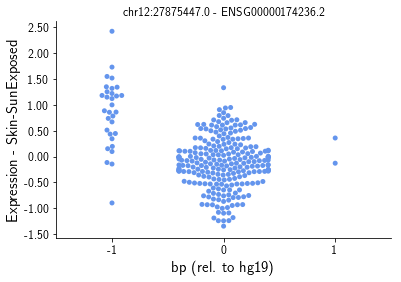

ENSG00000175575.8,11,73637141.0,Adipose-Subcutaneous AAAG 1.0


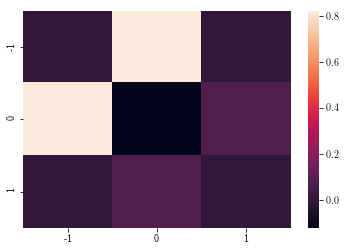

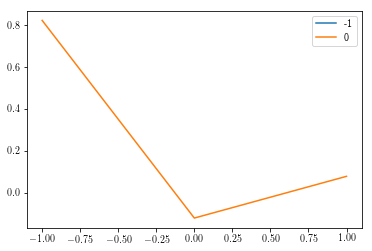

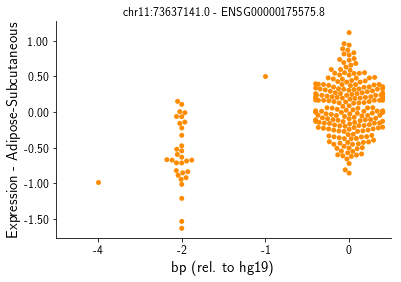

ENSG00000042286.10,10,71984970.0,Esophagus-Mucosa AAAT 1.0


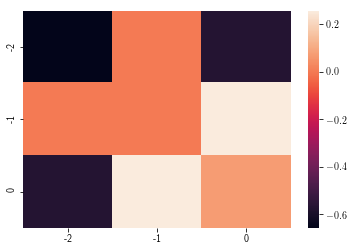

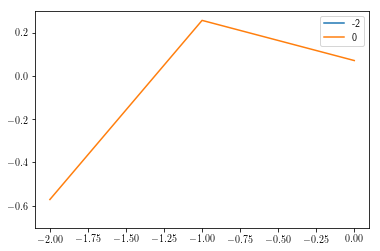

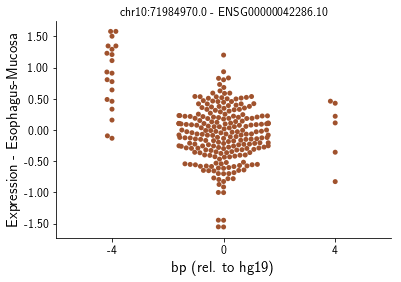

ENSG00000149089.8,11,34898691.0,Skin-SunExposed AAT 1.0


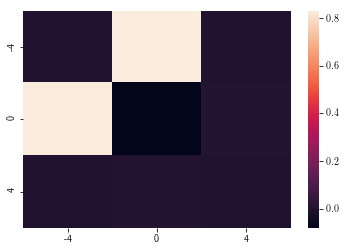

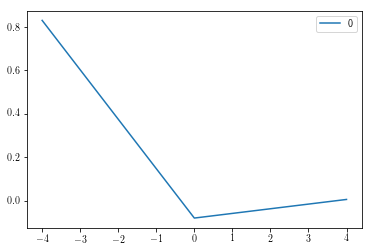

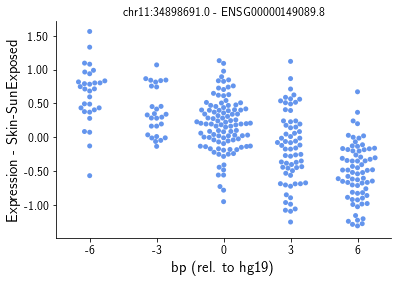

ENSG00000188659.5,15,82475166.0,Artery-Aorta A 0.999999


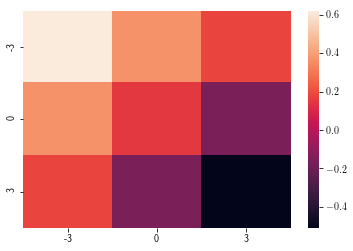

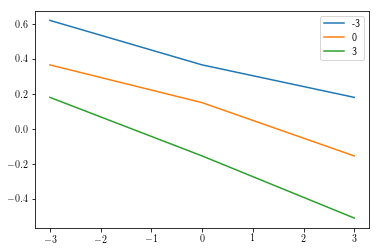

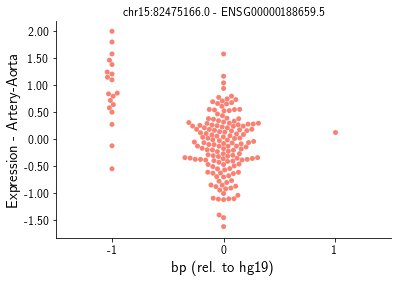

ENSG00000160213.5,21,45196326.0,Thyroid CCCCG 0.999998


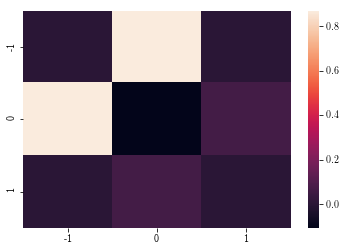

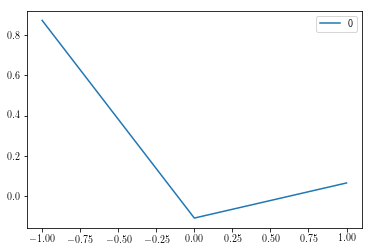

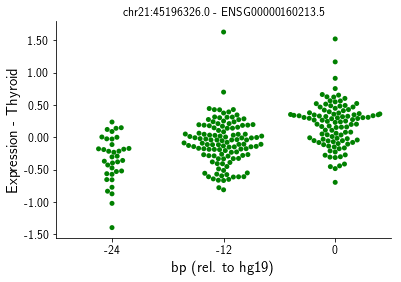

ENSG00000185619.13,4,741664.0,Cells-Transformedfibroblasts A 0.999994


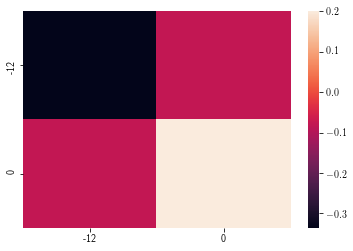

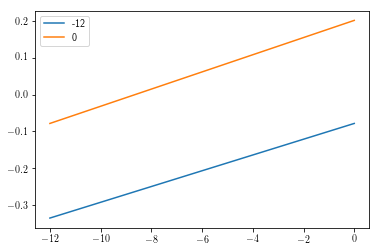

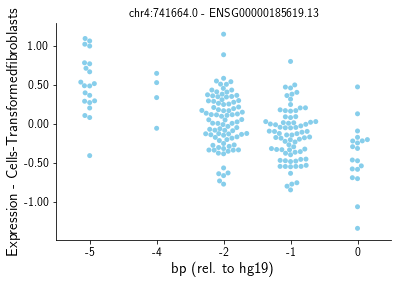

ENSG00000240563.1,1,62650593.0,Nerve-Tibial AT 0.999994


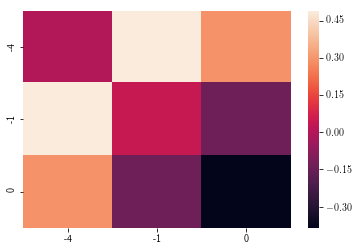

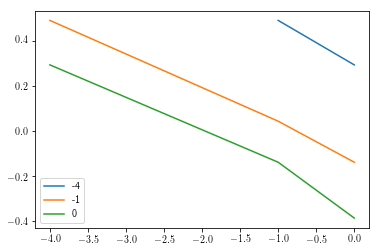

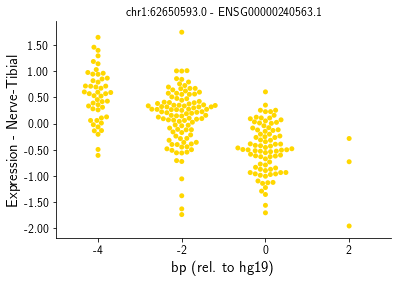

ENSG00000108352.7,17,38236658.0,WholeBlood A 0.999979


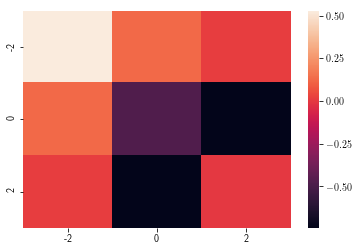

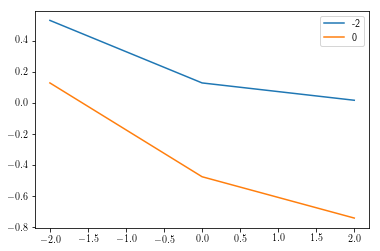

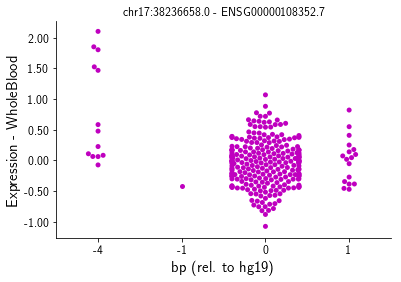

ENSG00000197782.10,19,40574238.0,Nerve-Tibial AGAT 0.999962


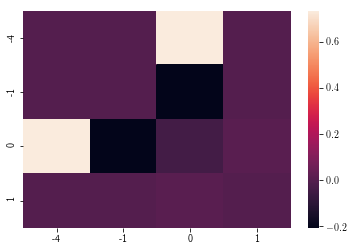

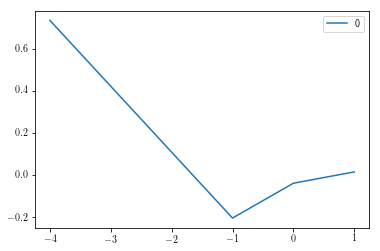

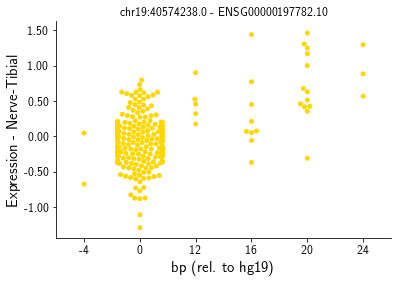

ENSG00000013275.3,19,40574238.0,Muscle-Skeletal AGAT 0.0408997


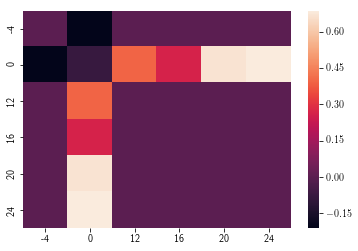

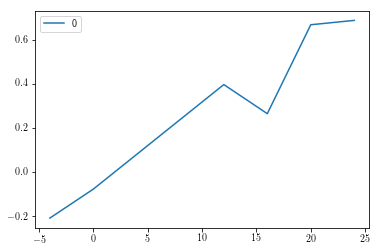

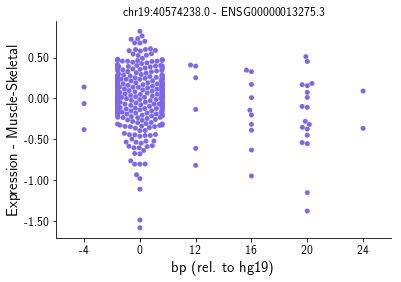

ENSG00000119392.10,9,131258994.0,Adipose-Subcutaneous AGAT 0.999959


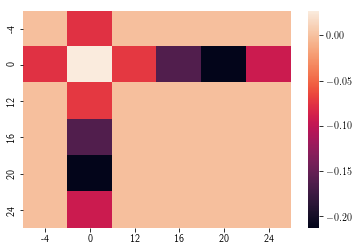

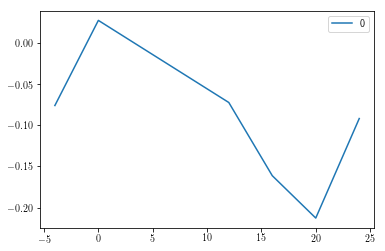

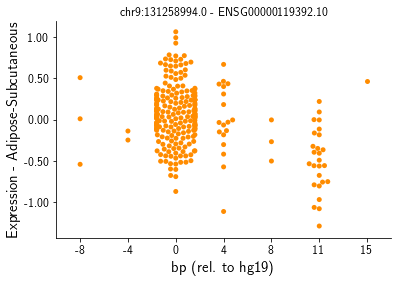

ENSG00000204396.6,6,31699087.0,Muscle-Skeletal A 0.9999


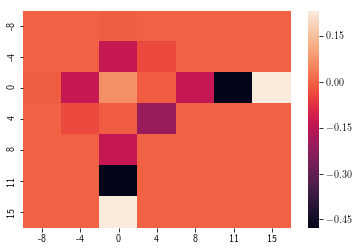

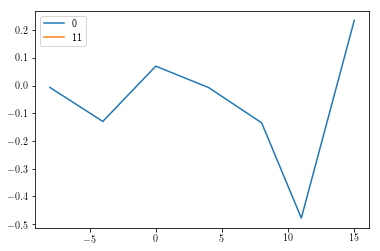

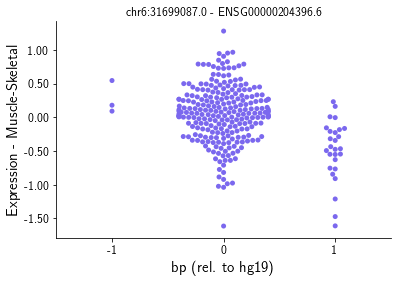

ENSG00000204439.3,6,31699087.0,Thyroid A 0.155974


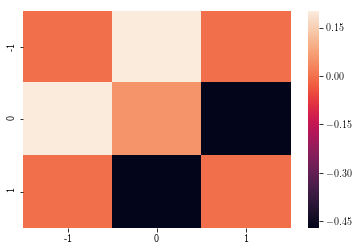

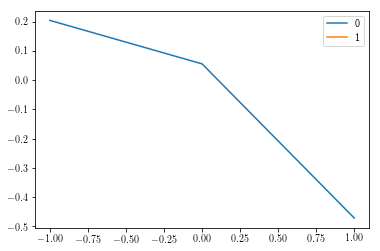

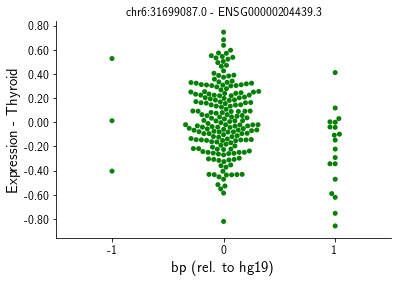

ENSG00000156990.10,3,9883164.0,Artery-Tibial AC 0.999894


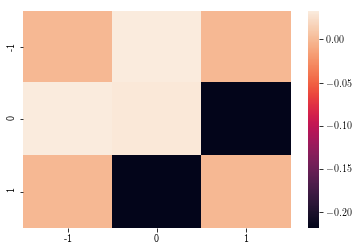

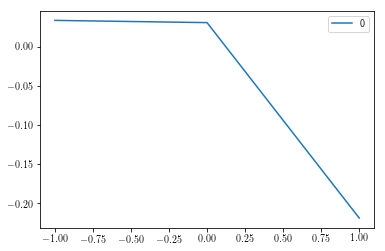

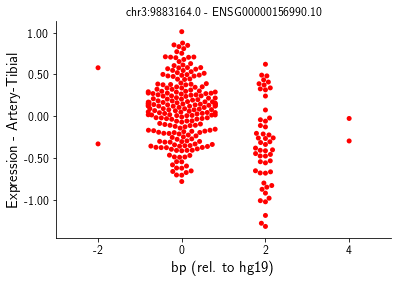

ENSG00000142102.11,11,297578.0,Skin-SunExposed AC 0.999879


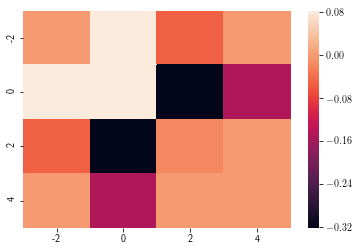

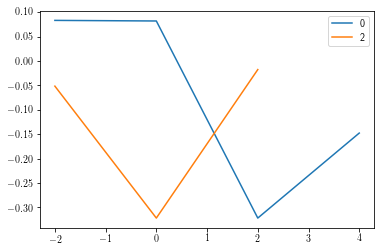

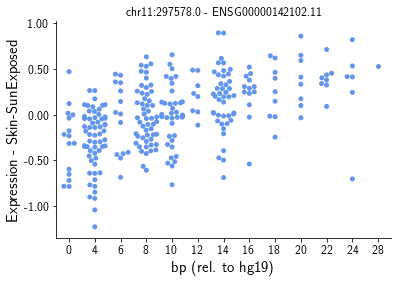

ENSG00000119326.10,9,111783775.0,Nerve-Tibial AAAAC 0.999703


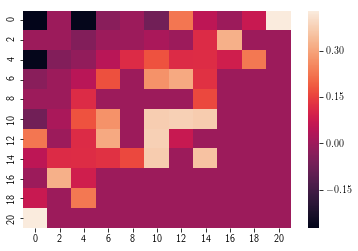

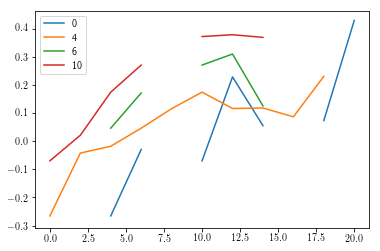

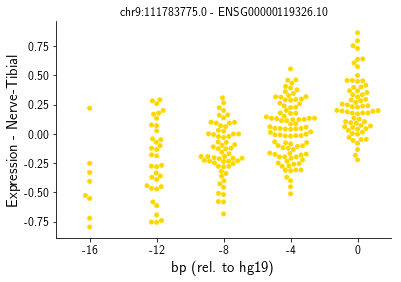

ENSG00000075975.11,3,12625265.0,Muscle-Skeletal AAAC 0.999665


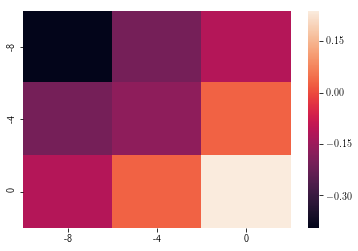

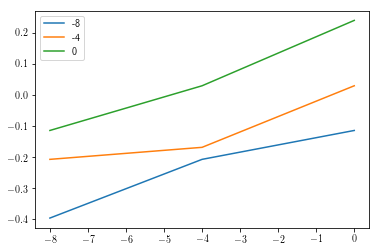

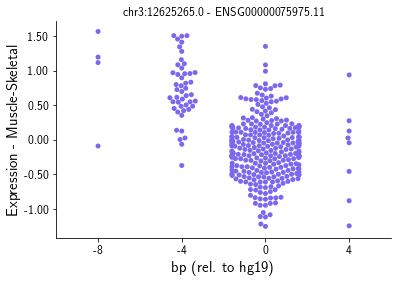

ENSG00000152689.13,2,33762260.0,Heart-LeftVentricle AT 0.999578


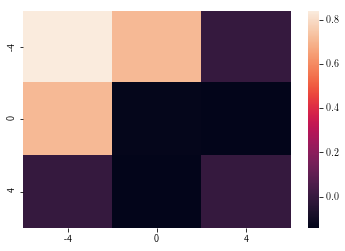

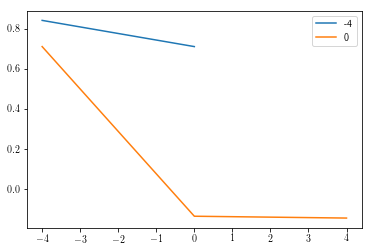

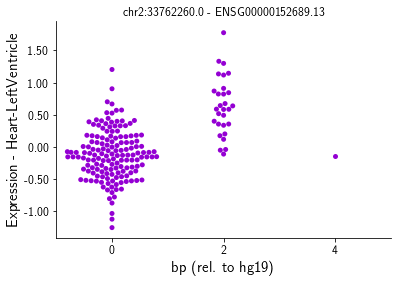

ENSG00000152642.6,3,32083114.0,Thyroid AAAG 0.999391


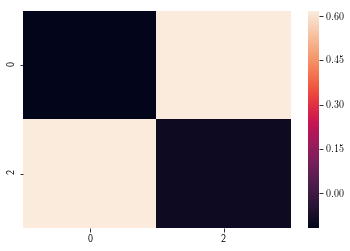

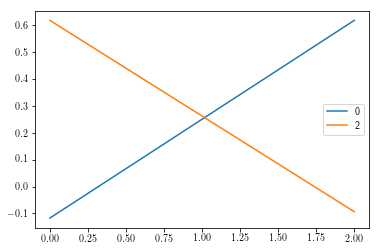

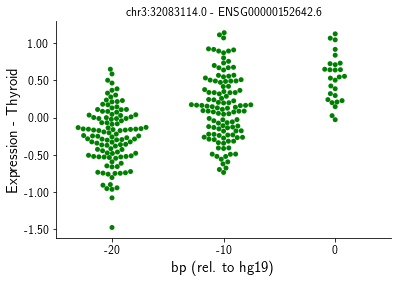

ENSG00000197385.5,3,32083114.0,Thyroid AAAG 0.251058


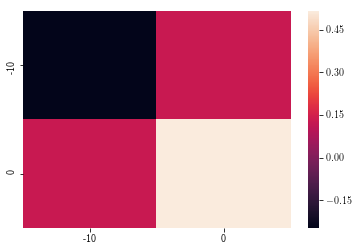

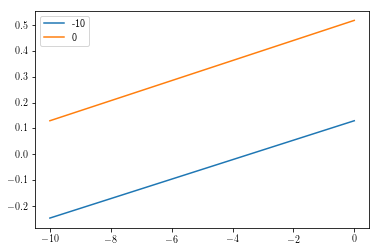

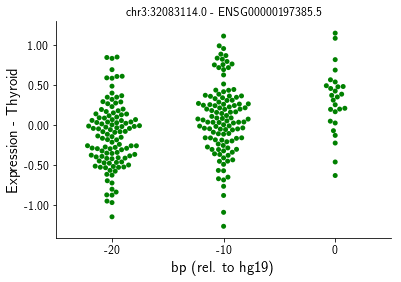

ENSG00000144645.9,3,32083114.0,Skin-NotSunExposed AAAG 0.0995744


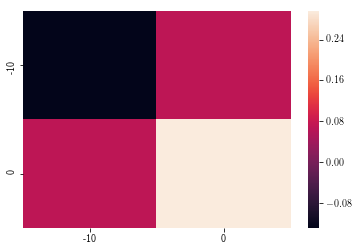

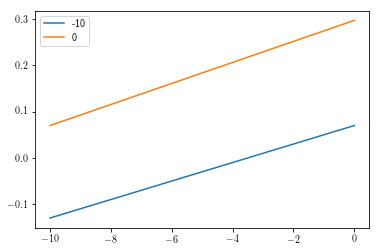

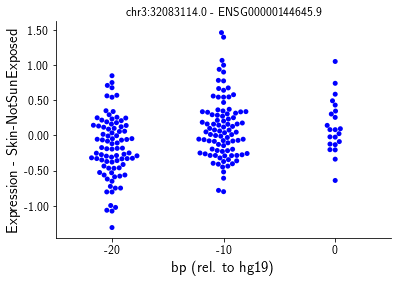

ENSG00000170162.9,6,117524057.0,Esophagus-Mucosa AT 0.999018


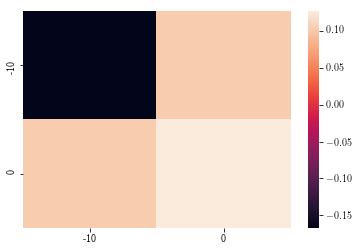

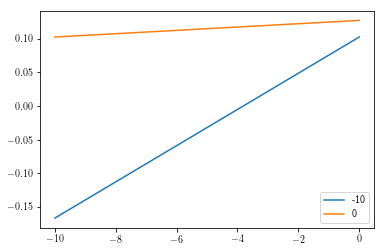

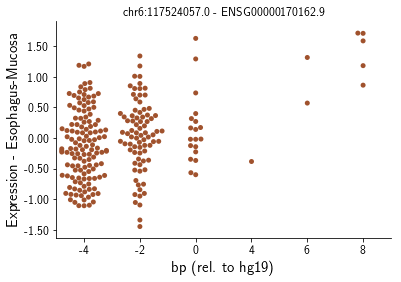

ENSG00000178297.8,19,2421294.0,WholeBlood A 0.998729


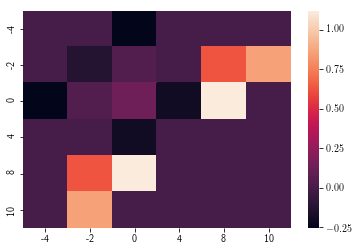

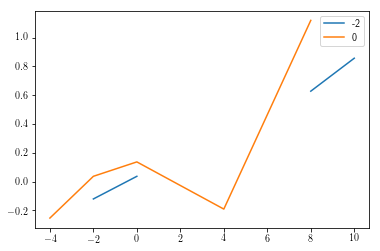

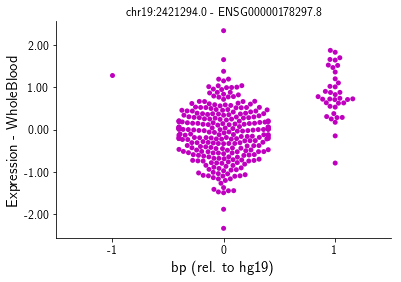

ENSG00000164054.11,3,48547593.0,Esophagus-Mucosa A 0.998439


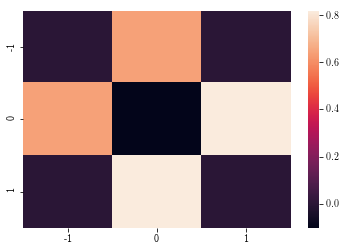

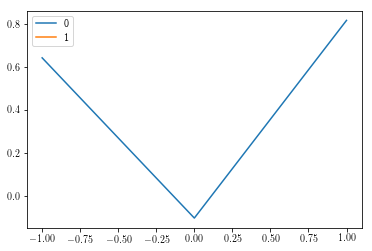

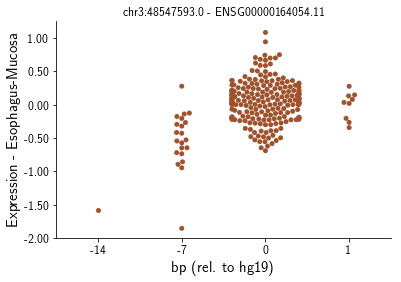

ENSG00000185298.8,17,79667664.0,Lung AGCCCC 0.998431


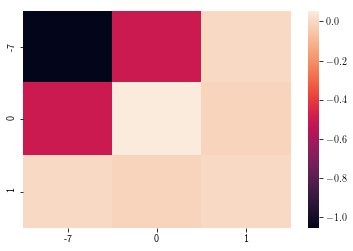

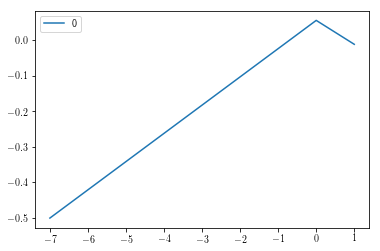

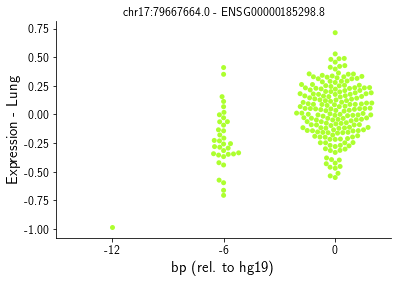

ENSG00000204237.4,17,79667664.0,Lung AGCCCC 0.15874000000000002


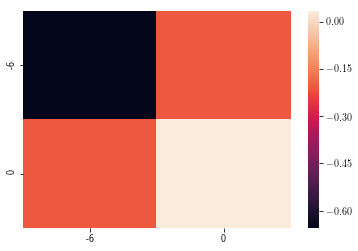

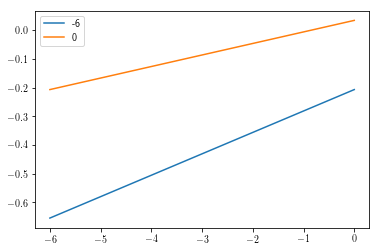

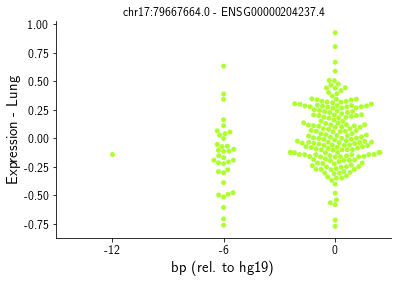

ENSG00000157379.9,14,24769850.0,Muscle-Skeletal AGG 0.998004


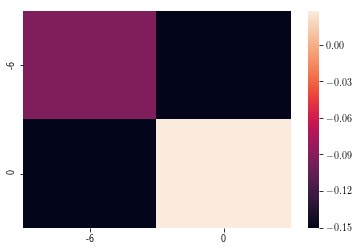

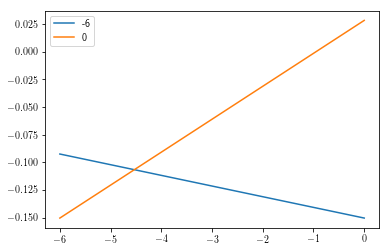

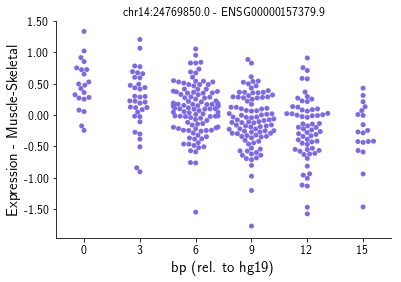

ENSG00000196943.8,14,24769850.0,Muscle-Skeletal AGG 0.0724318


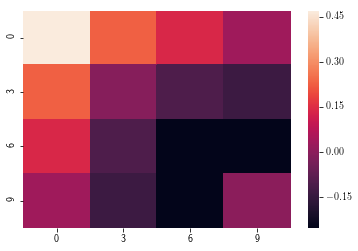

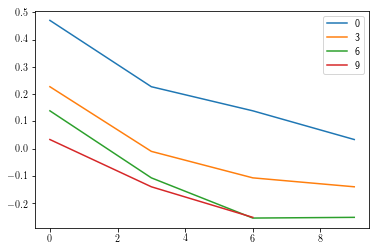

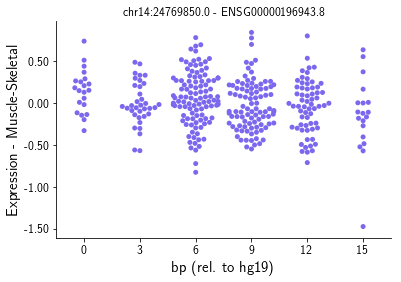

ENSG00000101361.10,20,2633379.0,Muscle-Skeletal AGGCCC 0.997788


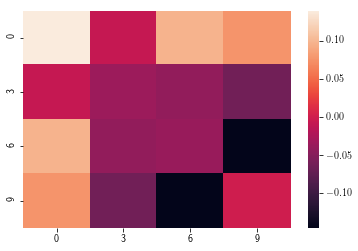

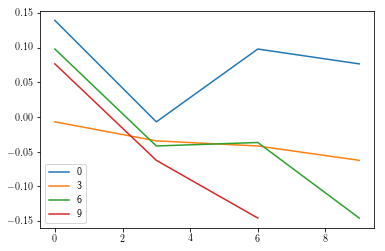

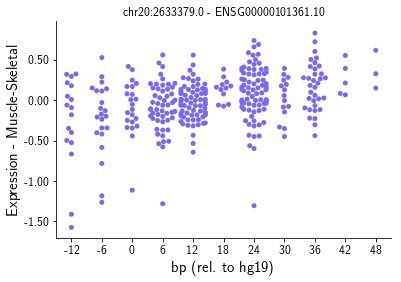

ENSG00000187815.5,1,40942699.0,Skin-SunExposed AATG 0.997784


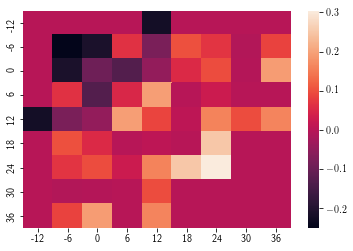

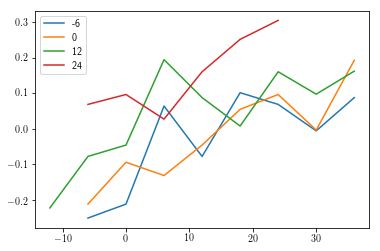

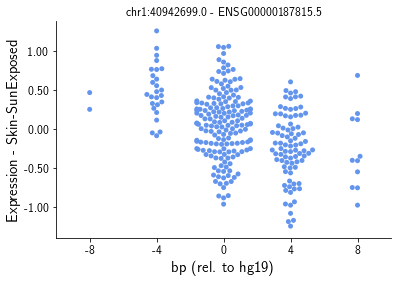

ENSG00000164002.7,1,40942699.0,Muscle-Skeletal AATG 0.690228


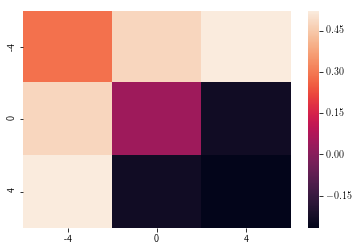

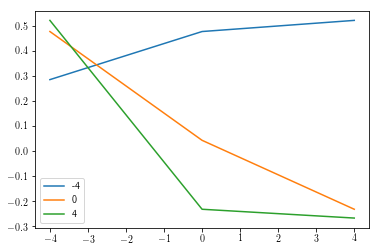

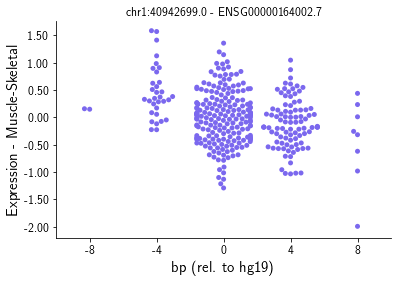

ENSG00000117010.11,1,40942699.0,Muscle-Skeletal AATG 0.169417


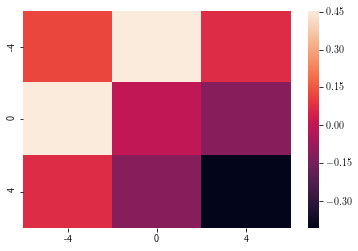

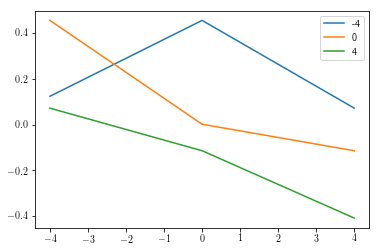

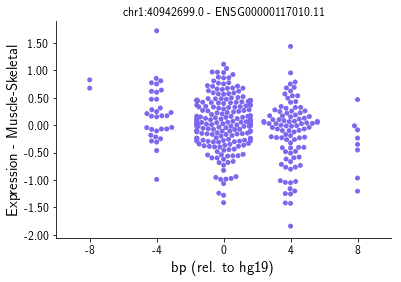

ENSG00000135049.11,9,88356815.0,Cells-Transformedfibroblasts CCG 0.997629


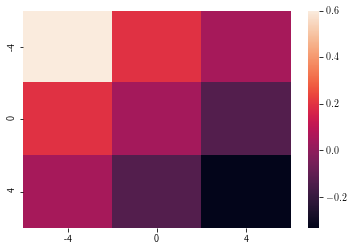

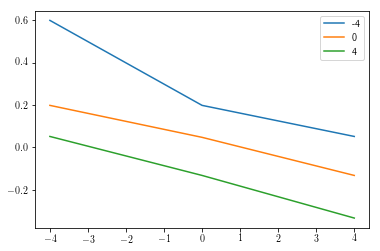

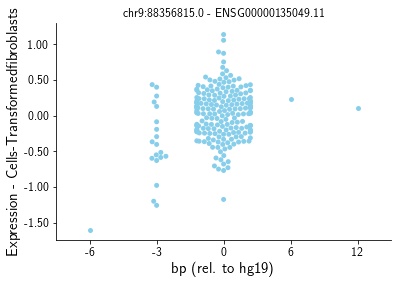

ENSG00000100124.8,22,38190675.0,Muscle-Skeletal AAAAC 0.997352


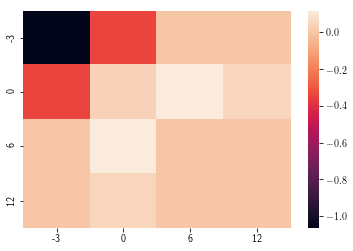

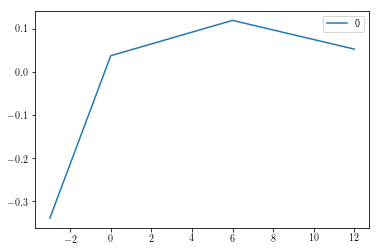

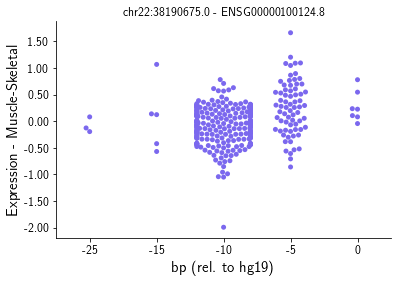

ENSG00000091640.3,17,4860836.0,Nerve-Tibial A 0.997041


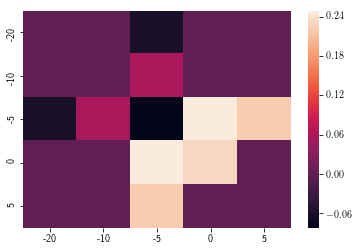

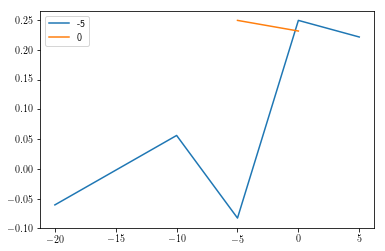

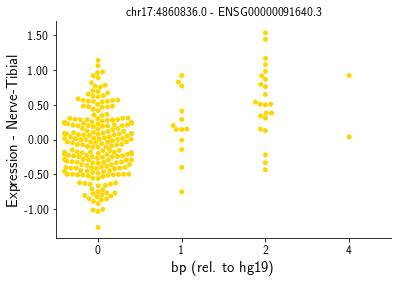

ENSG00000186501.10,1,27600312.0,Artery-Tibial AC 0.997034


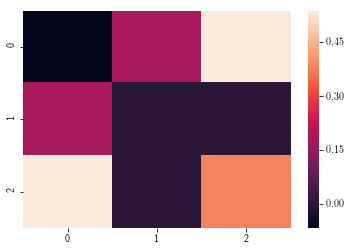

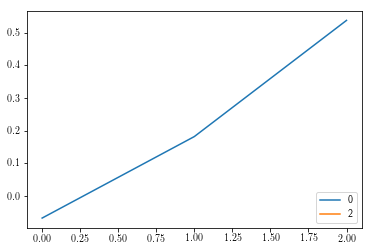

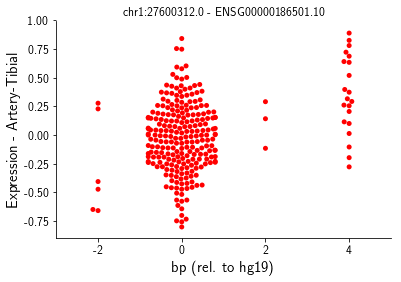

ENSG00000205307.6,7,100172242.0,Brain-Cerebellum AC 0.996996


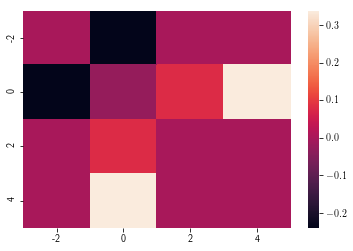

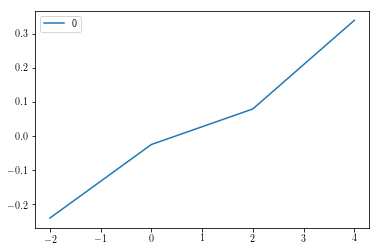

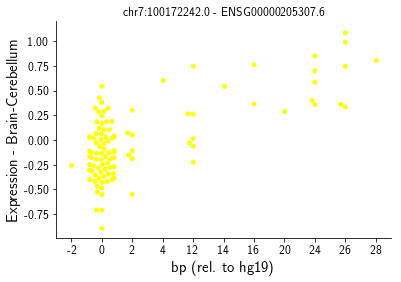

ENSG00000077454.11,7,100172242.0,Esophagus-Muscularis AC 0.806443


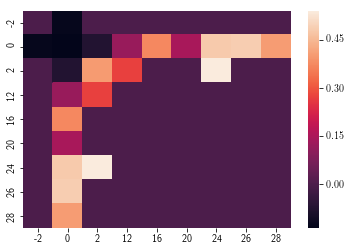

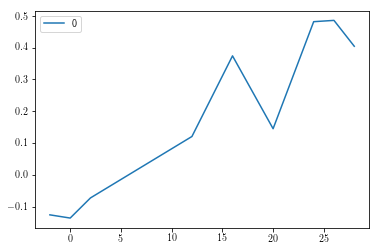

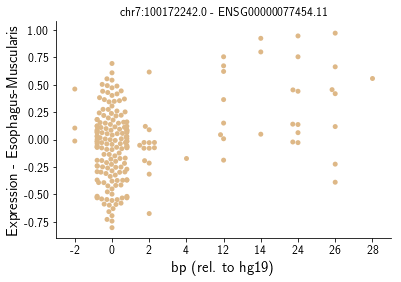

ENSG00000169612.3,15,83640121.0,Esophagus-Muscularis AG 0.996983


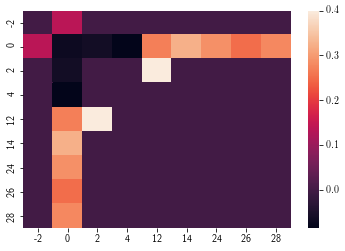

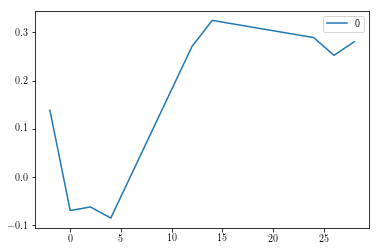

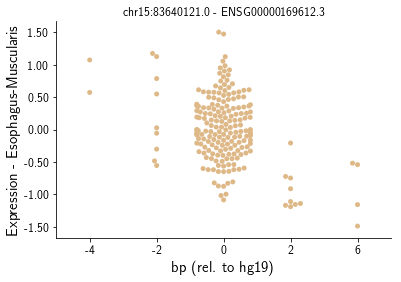

ENSG00000187987.5,6,28419904.0,Esophagus-Muscularis AC 0.996898


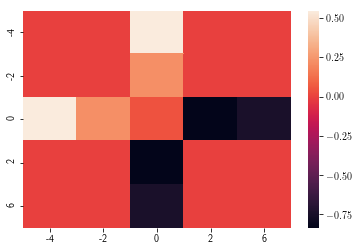

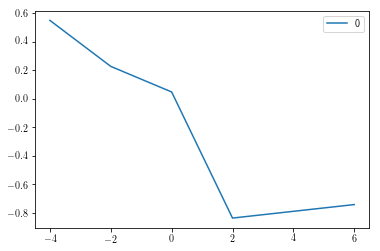

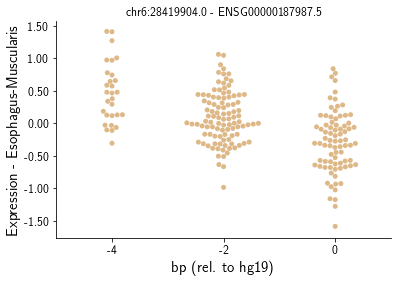

ENSG00000213214.3,7,143803741.0,Esophagus-Mucosa AAAC 0.996838


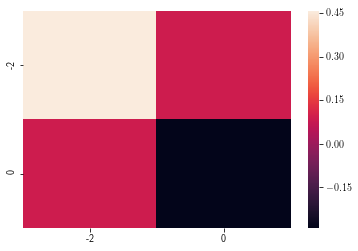

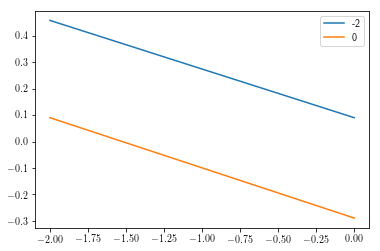

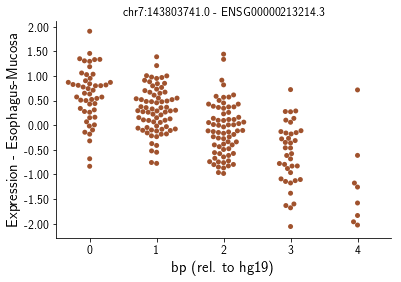

ENSG00000221836.2,7,143803741.0,Thyroid AAAC 0.130704


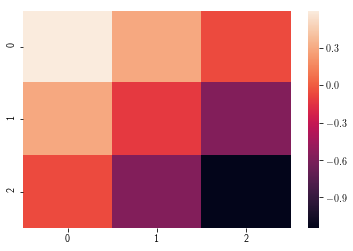

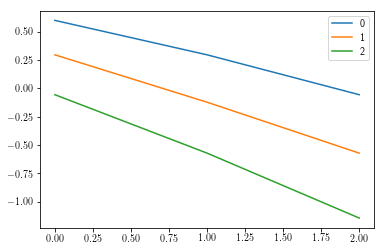

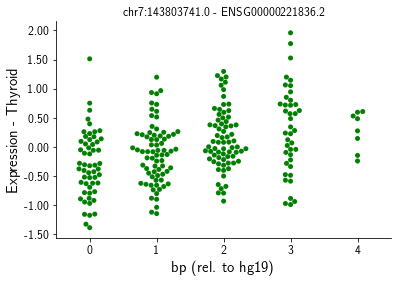

ENSG00000100350.10,22,36893227.0,Heart-LeftVentricle A 0.996794


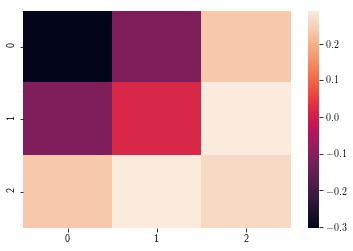

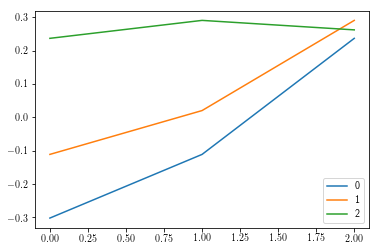

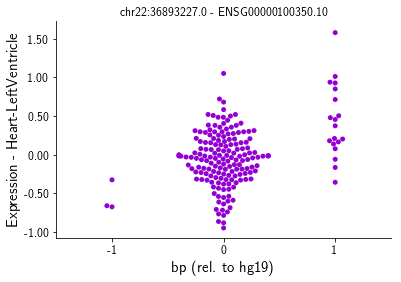

ENSG00000142798.12,1,22158736.0,Skin-NotSunExposed AATG 0.996561


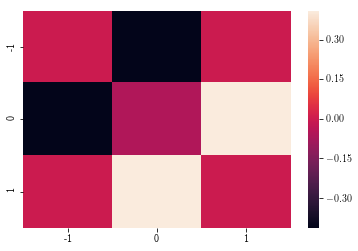

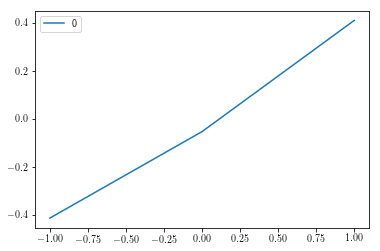

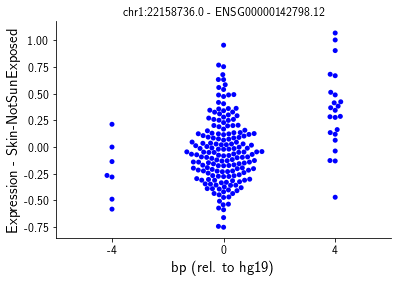

ENSG00000130768.10,1,28250549.0,Lung A 0.996349


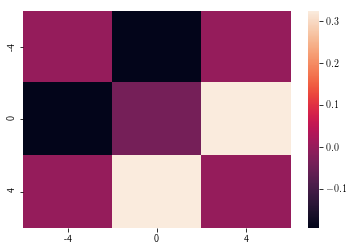

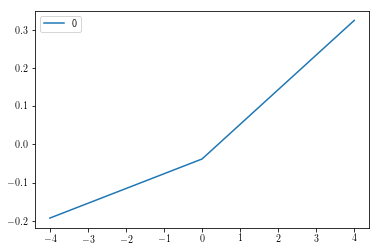

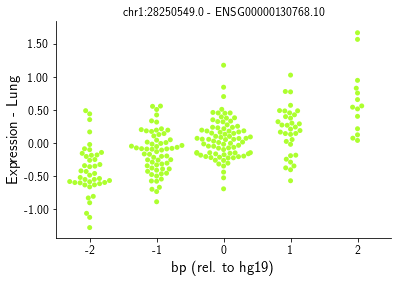

ENSG00000149657.15,20,60673851.0,Brain-Cerebellum A 0.995351


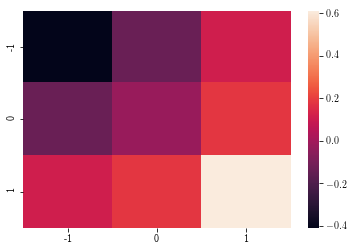

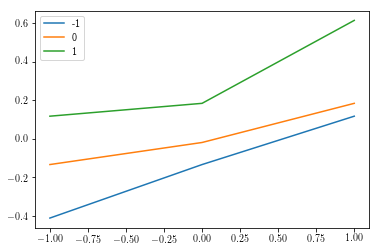

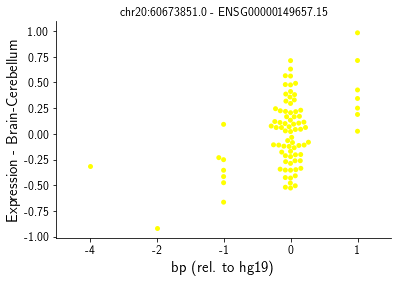

ENSG00000157326.14,14,24392239.0,Skin-SunExposed AC 0.995207


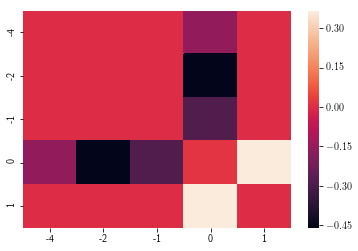

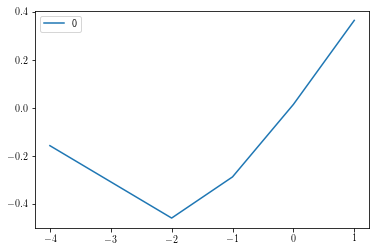

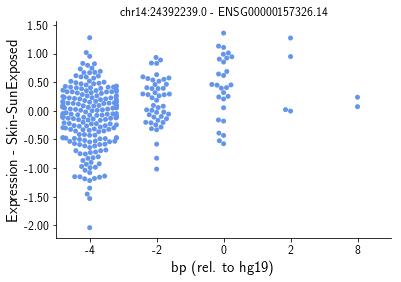

ENSG00000128891.11,15,40871658.0,Artery-Tibial A 0.994461


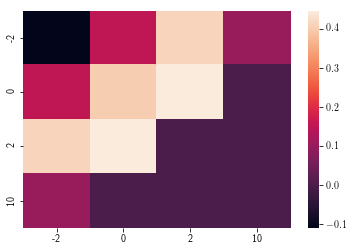

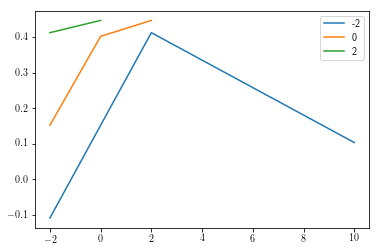

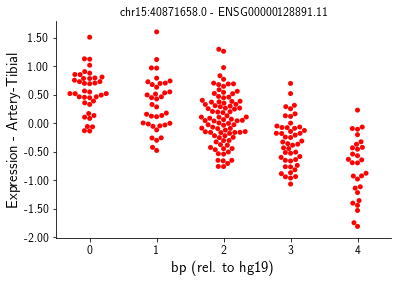

ENSG00000183628.8,22,18924558.0,Adipose-Subcutaneous A 0.993779


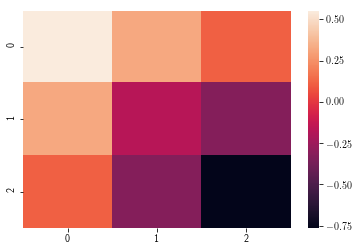

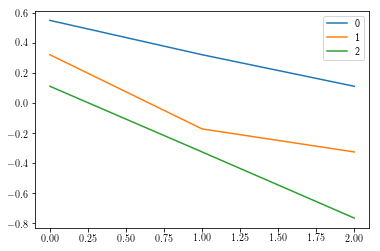

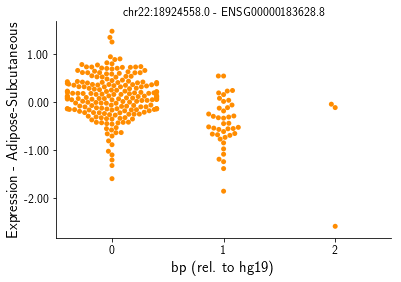

ENSG00000109854.9,11,20384871.0,Esophagus-Muscularis AC 0.993284


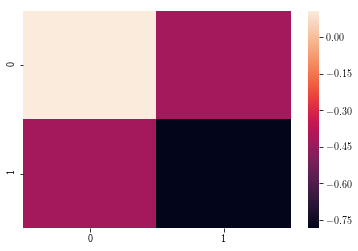

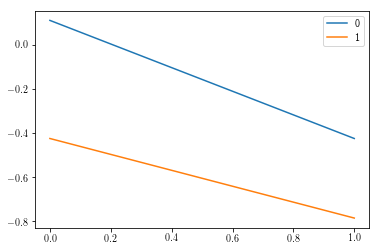

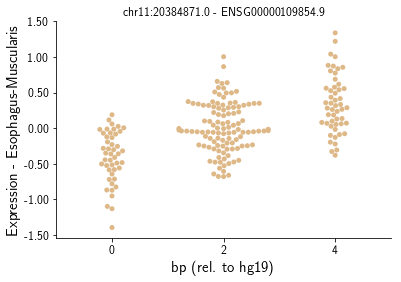

ENSG00000096872.11,9,26979150.0,Skin-NotSunExposed A 0.991753


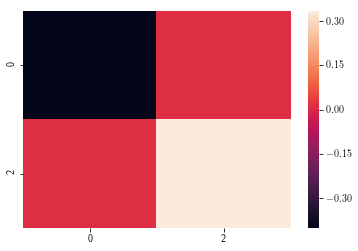

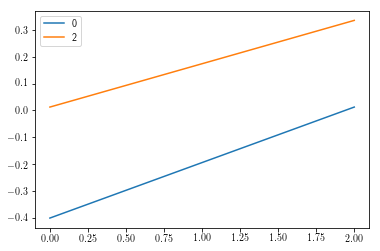

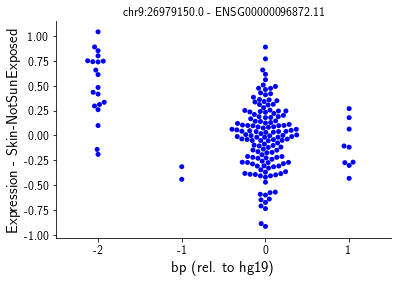

ENSG00000114948.8,2,207390866.0,Muscle-Skeletal AC 0.990765


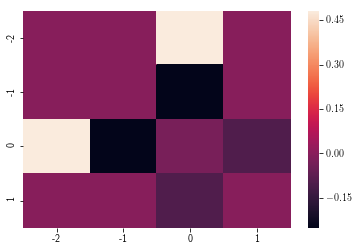

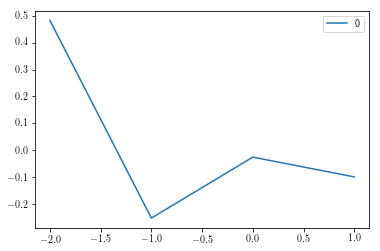

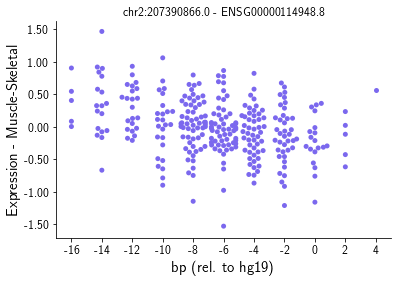

ENSG00000120262.8,6,151796605.0,WholeBlood A 0.989427


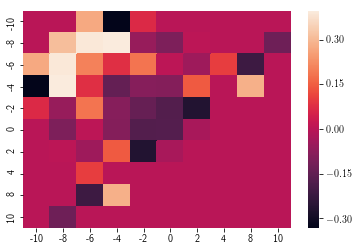

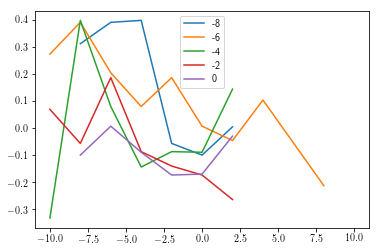

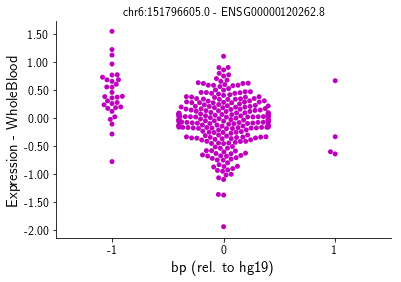

ENSG00000160818.12,1,156570363.0,Muscle-Skeletal A 0.988064


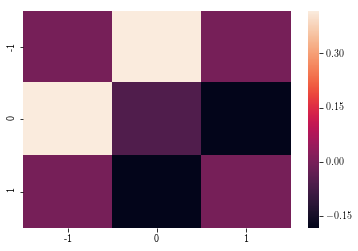

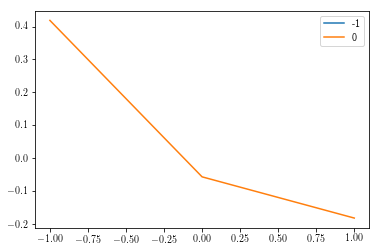

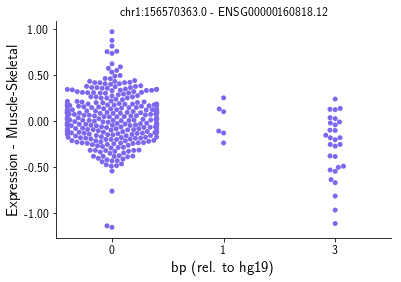

ENSG00000188846.9,3,40503521.0,Nerve-Tibial AGC 0.988014


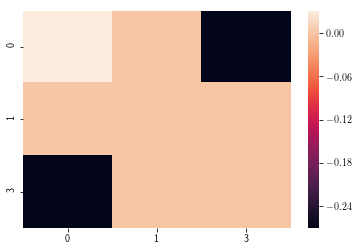

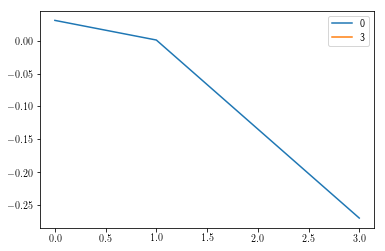

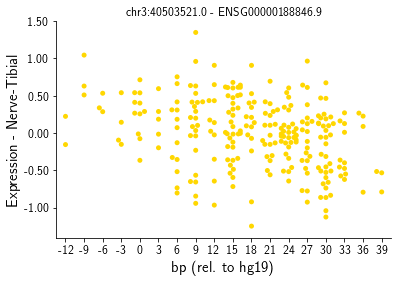

ENSG00000126464.9,19,50110619.0,Thyroid AC 0.987714


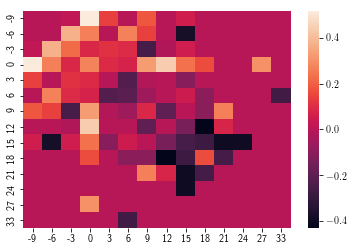

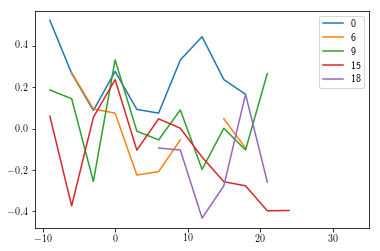

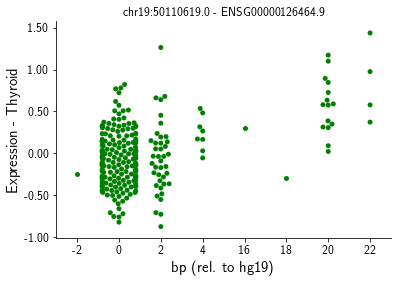

ENSG00000130363.7,6,159419918.0,Nerve-Tibial ACC 0.98647


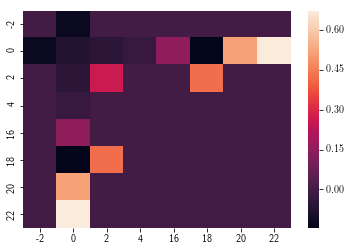

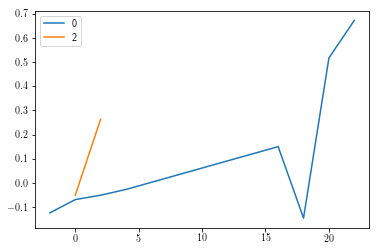

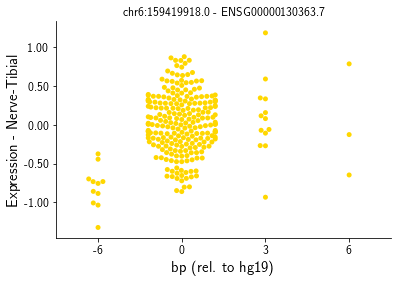

ENSG00000146350.9,6,121415323.0,Nerve-Tibial A 0.984651


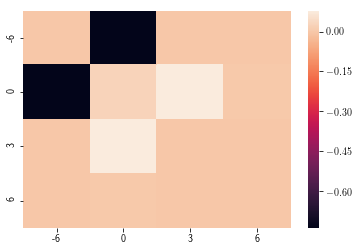

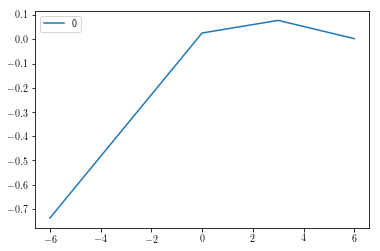

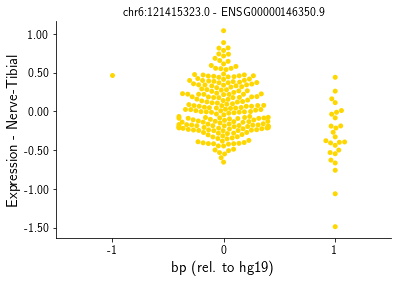

ENSG00000249992.1,3,45297762.0,Brain-Cerebellum A 0.982747


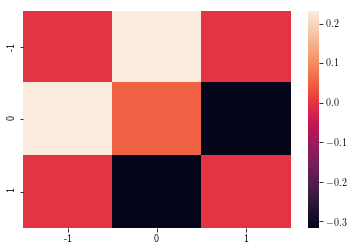

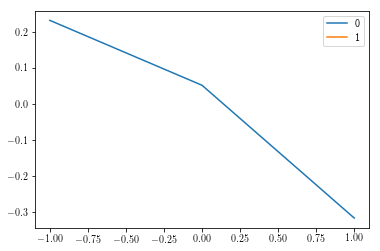

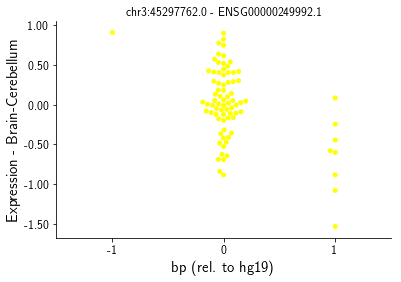

ENSG00000163629.8,4,87744515.0,Thyroid A 0.981375


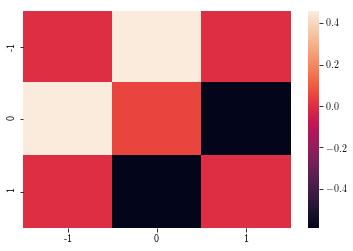

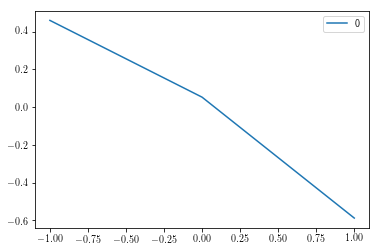

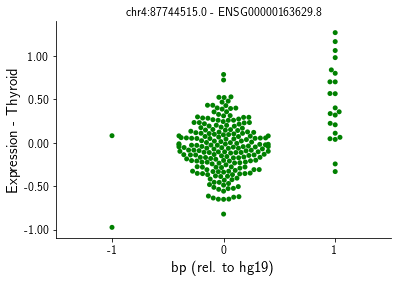

ENSG00000075131.5,15,66606190.0,Esophagus-Muscularis AT 0.977213


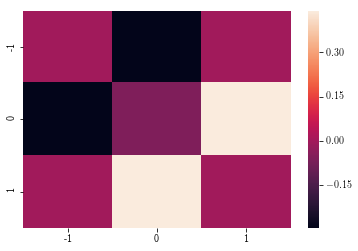

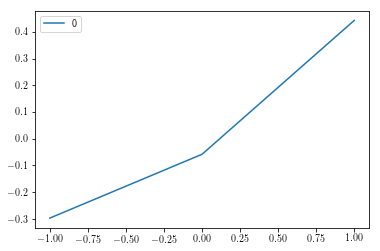

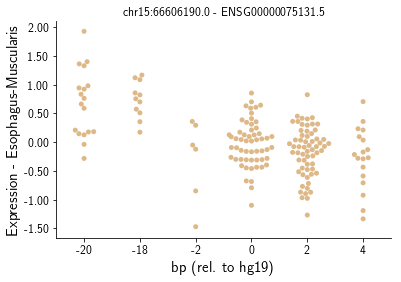

ENSG00000156968.8,16,15519988.0,Muscle-Skeletal AAAAC 0.975825


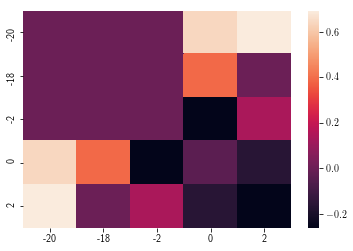

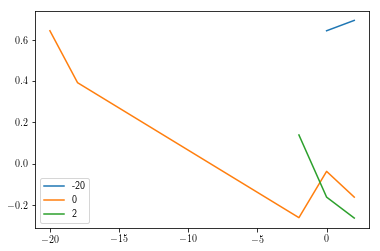

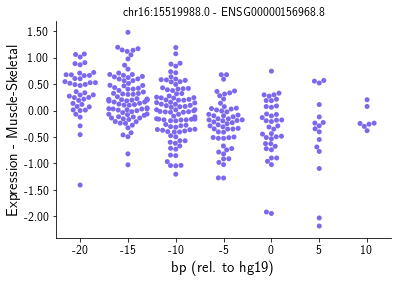

ENSG00000028528.10,15,64440177.0,Esophagus-Mucosa A 0.975012


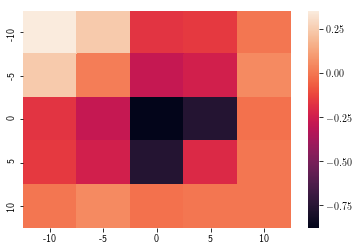

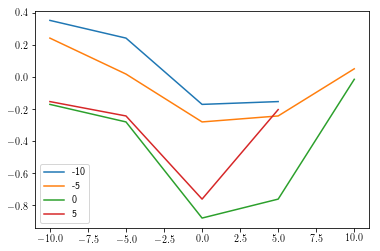

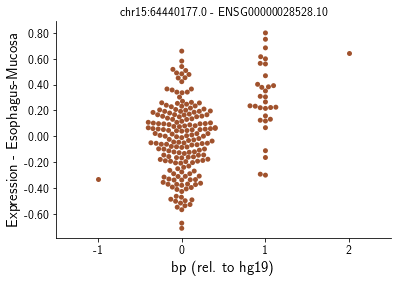

ENSG00000108828.11,17,41106450.0,Skin-NotSunExposed A 0.972938


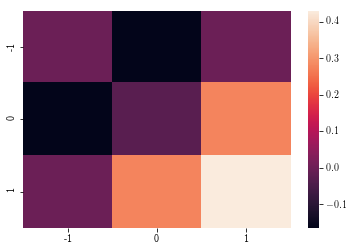

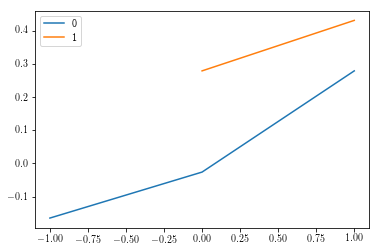

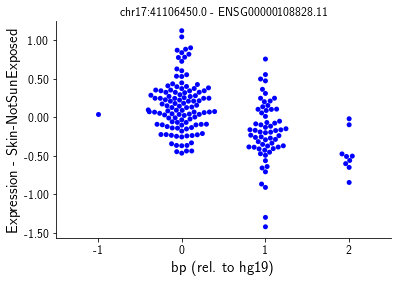

ENSG00000123427.11,12,58167195.0,Brain-Cerebellum A 0.971733


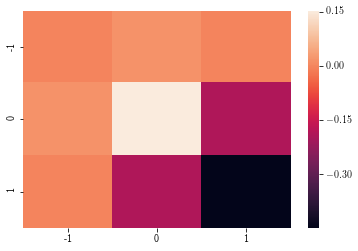

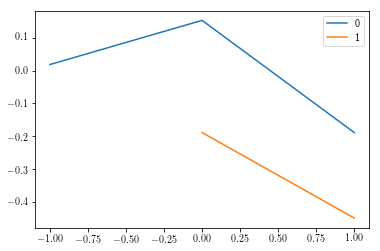

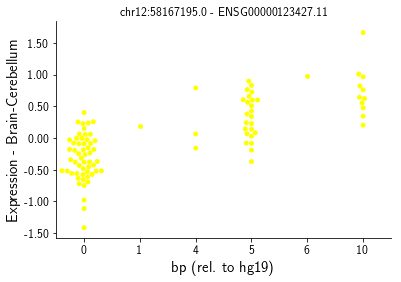

ENSG00000223865.6,6,33070643.0,Cells-Transformedfibroblasts A 0.971069


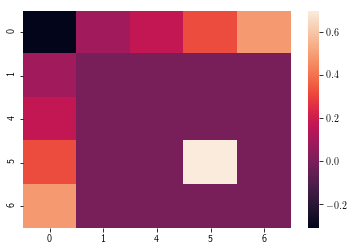

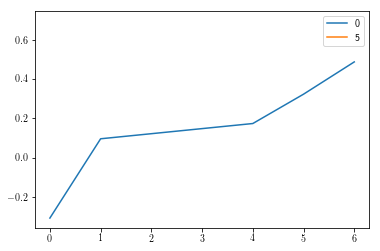

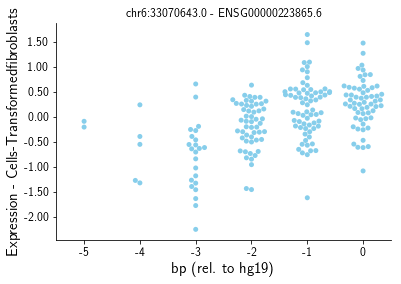

ENSG00000253598.1,8,82600900.0,Brain-Cerebellum AAAG 0.962151


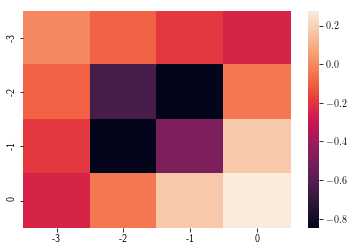

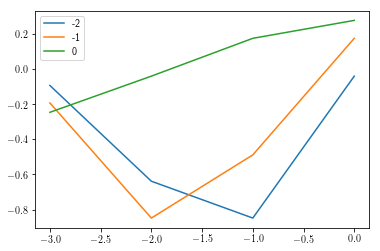

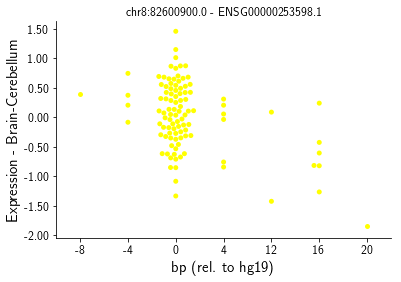

ENSG00000164695.4,8,82600900.0,Skin-SunExposed AAAG 0.859599


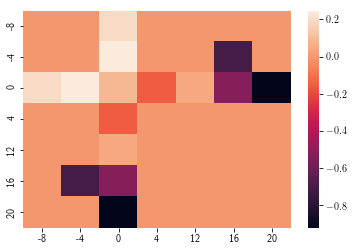

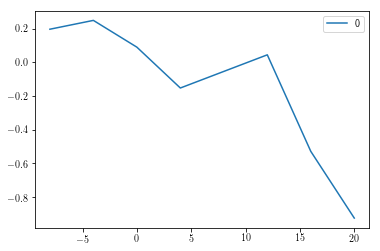

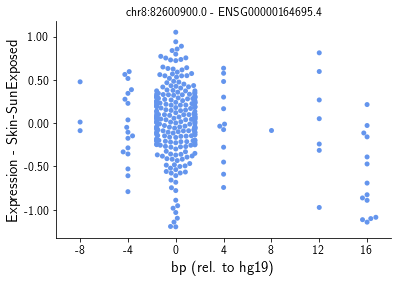

ENSG00000167264.13,16,68118032.0,WholeBlood A 0.961474


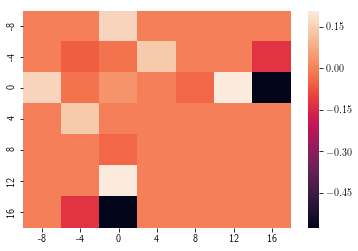

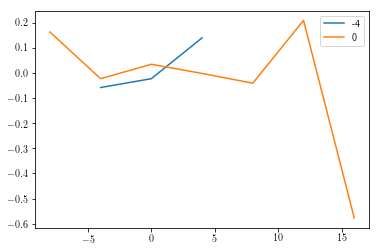

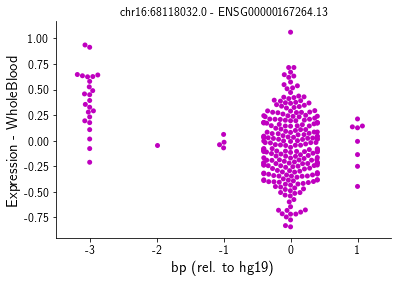

ENSG00000183172.8,22,42433835.0,Brain-Cerebellum AC 0.96028


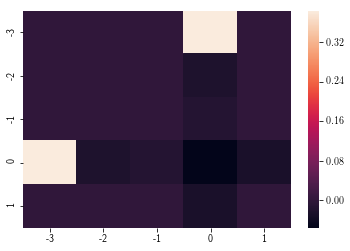

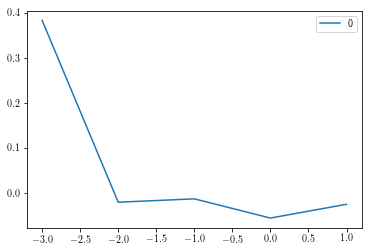

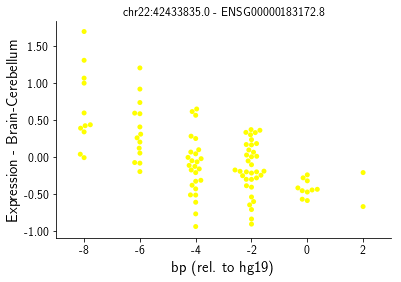

ENSG00000184983.5,22,42433835.0,Artery-Tibial AC 0.433358


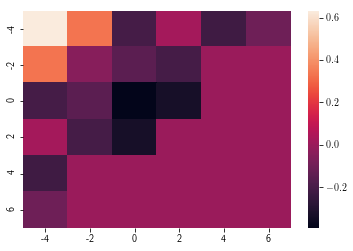

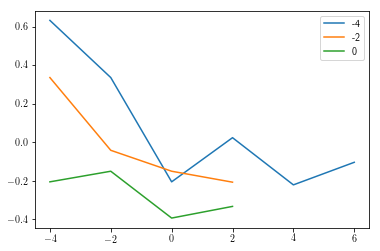

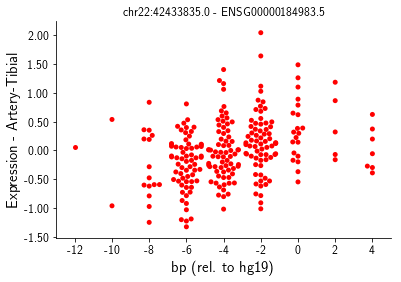

ENSG00000100167.15,22,42433835.0,Adipose-Visceral AC 0.119247


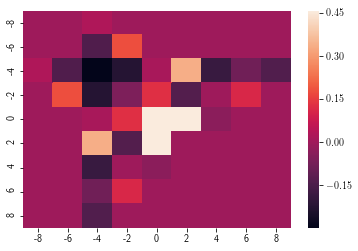

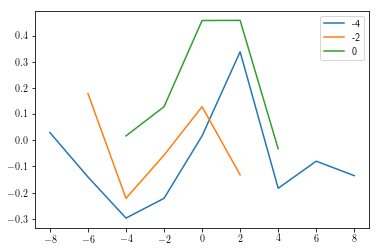

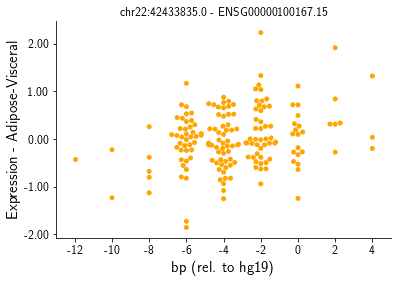

ENSG00000075643.5,18,33771714.0,Artery-Aorta AC 0.958133


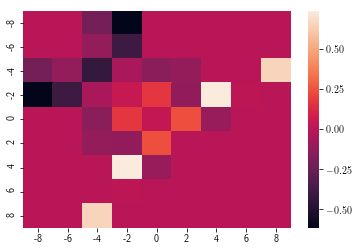

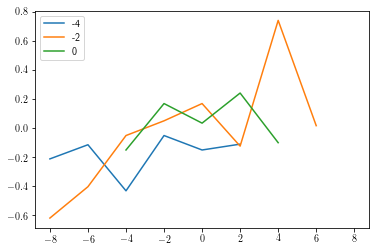

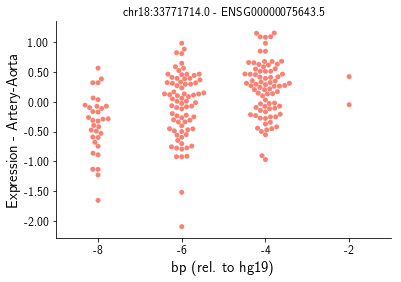

ENSG00000024862.12,6,139096074.0,Muscle-Skeletal AAAAC 0.958086


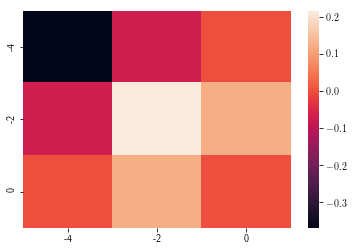

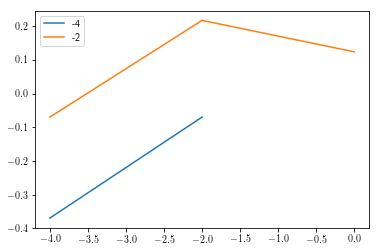

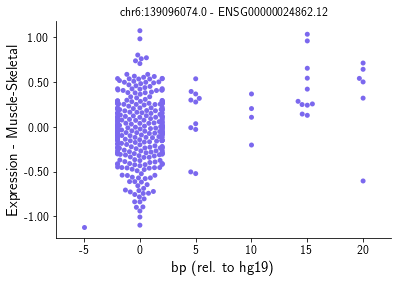

ENSG00000171806.7,1,169759316.0,Brain-Cerebellum A 0.957622


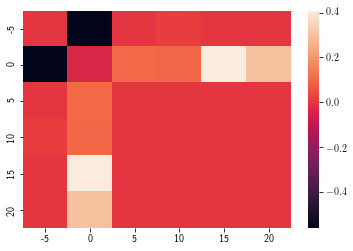

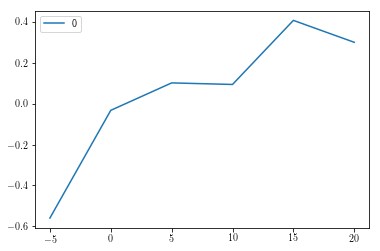

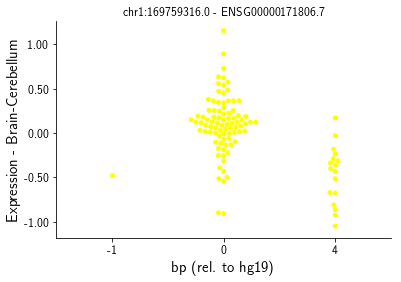

ENSG00000072832.10,4,5824221.0,Artery-Tibial C 0.953349


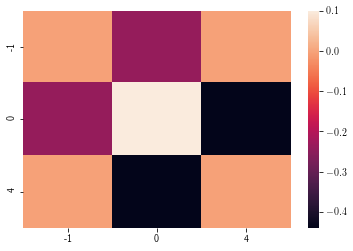

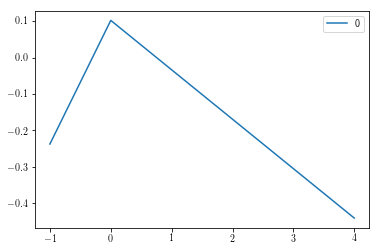

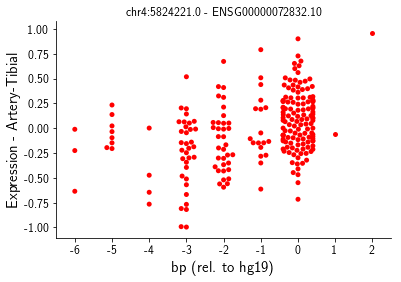

ENSG00000104980.3,19,8075650.0,Brain-Cerebellum A 0.952006


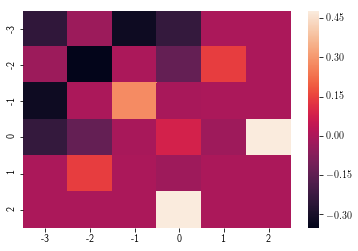

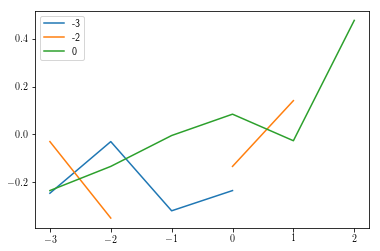

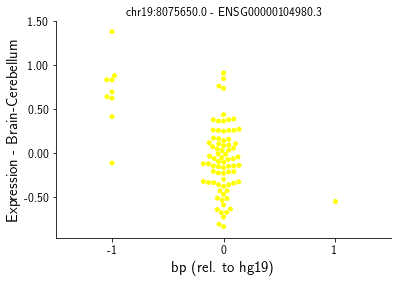

ENSG00000107593.15,10,102029009.0,WholeBlood A 0.94933


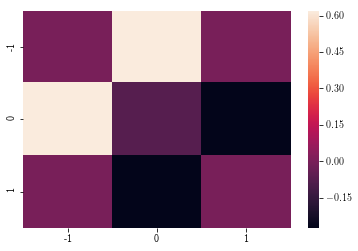

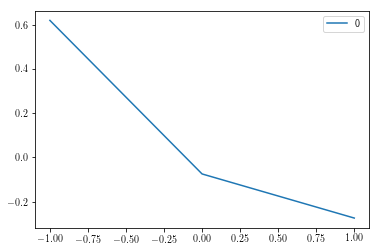

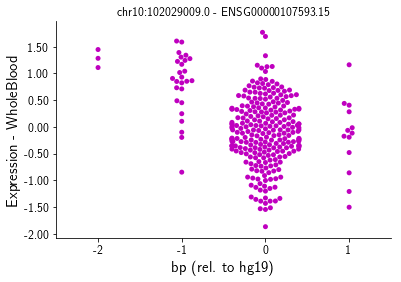

ENSG00000196072.7,10,102029009.0,Artery-Aorta A 0.232341


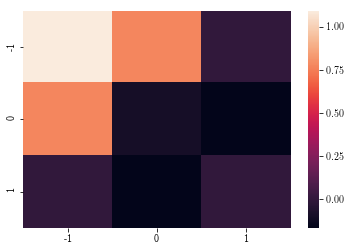

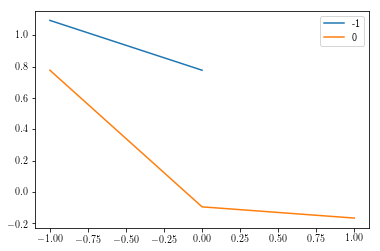

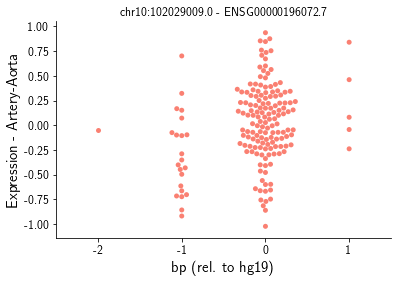

ENSG00000160072.15,1,1437601.0,Thyroid A 0.948717


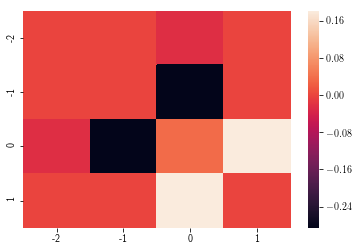

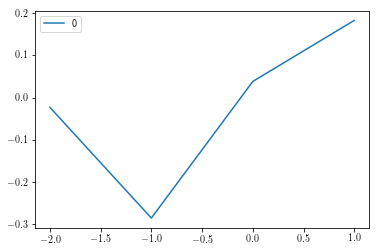

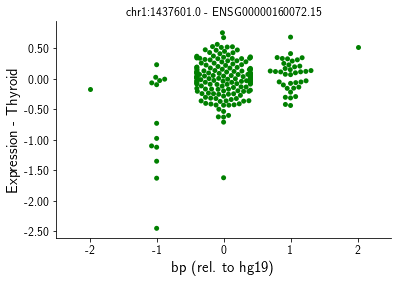

ENSG00000006576.12,7,77557804.0,Artery-Tibial A 0.948084


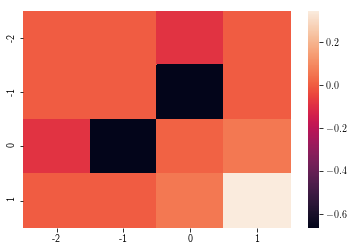

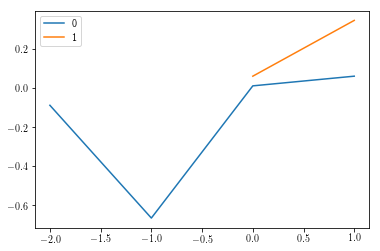

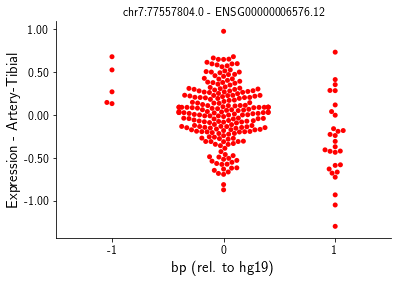

ENSG00000171045.10,8,143446958.0,Heart-LeftVentricle AC 0.947378


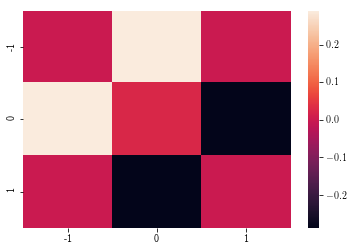

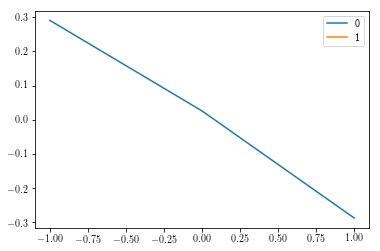

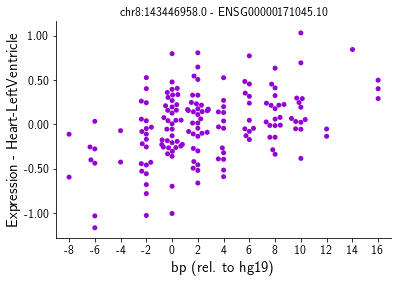

ENSG00000187715.9,3,127638629.0,Artery-Tibial AT 0.947356


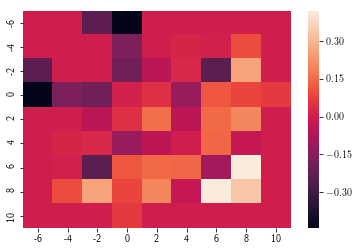

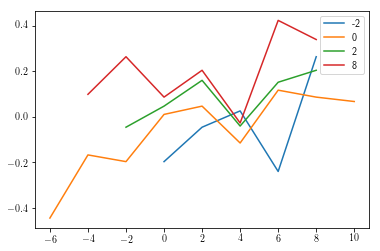

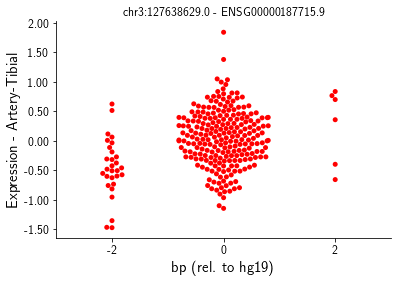

ENSG00000186204.10,19,15816403.0,Adipose-Subcutaneous A 0.946636


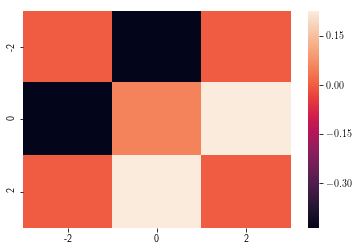

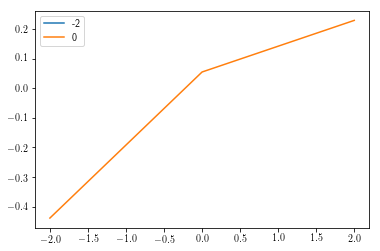

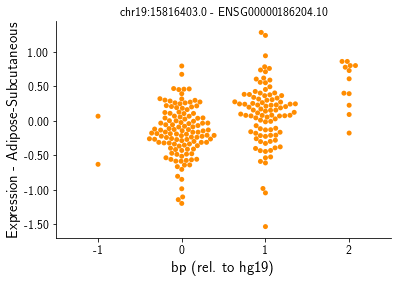

ENSG00000115073.6,2,98263312.0,Adipose-Subcutaneous A 0.945647


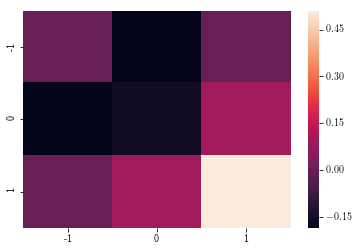

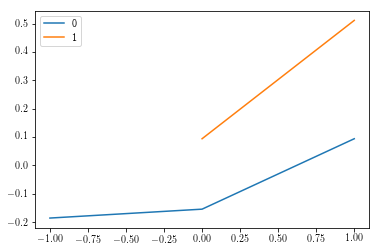

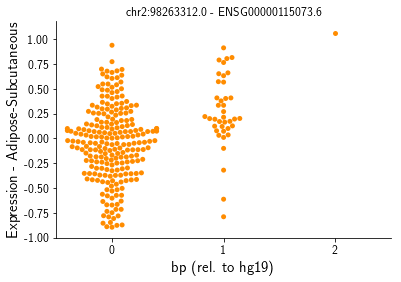

ENSG00000197448.9,7,142980963.0,Skin-NotSunExposed AC 0.94384


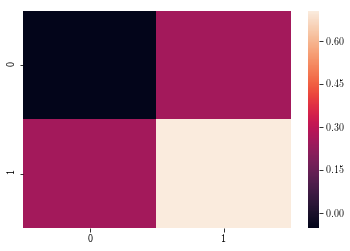

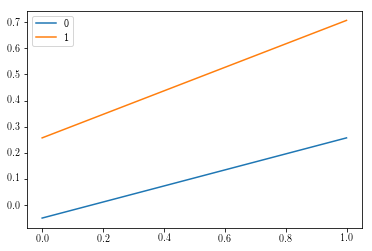

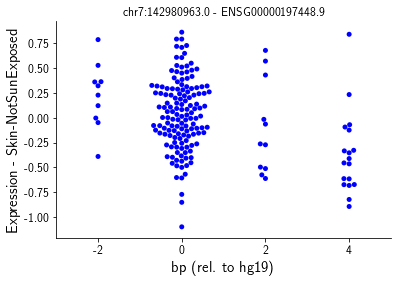

ENSG00000188037.6,7,142980963.0,Artery-Tibial AC 0.0843325


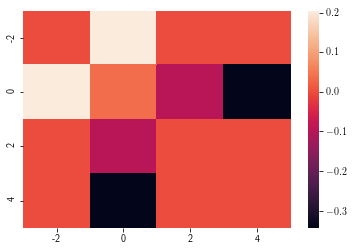

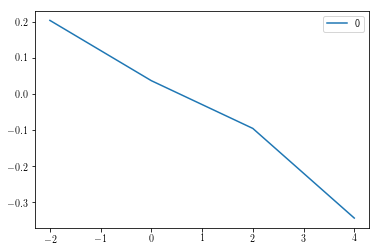

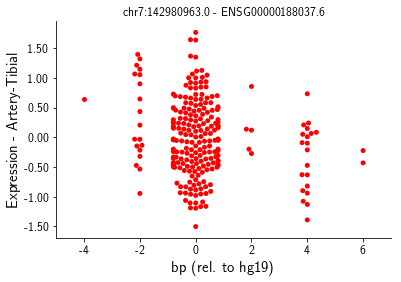

ENSG00000204516.5,6,31479844.0,Cells-Transformedfibroblasts A 0.942395


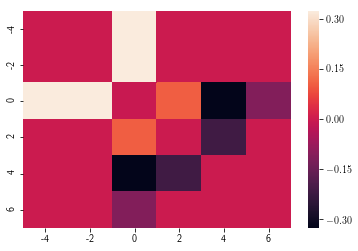

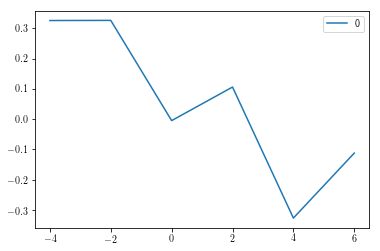

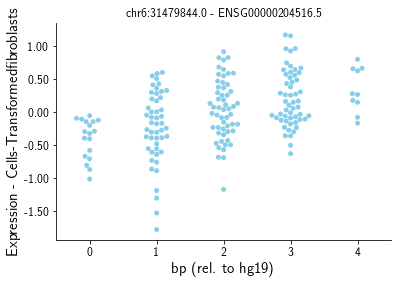

ENSG00000164841.4,8,109773203.0,Heart-LeftVentricle AC 0.942045


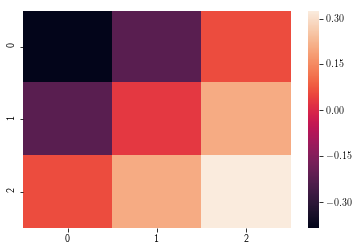

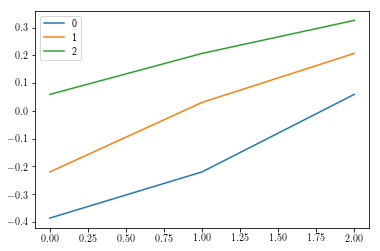

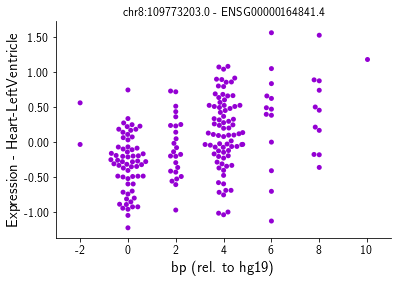

ENSG00000139370.6,12,129278282.0,Artery-Aorta A 0.940508


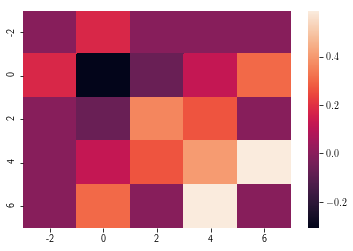

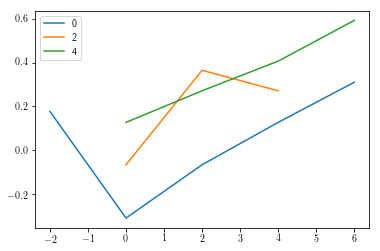

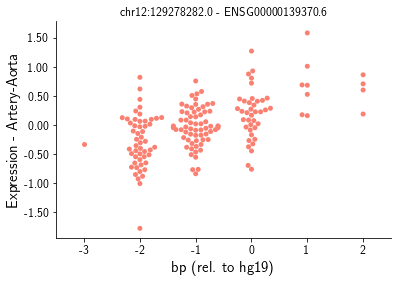

ENSG00000083544.9,13,61016506.0,Muscle-Skeletal AC 0.938224


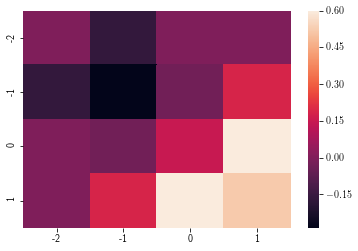

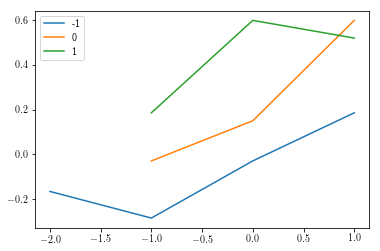

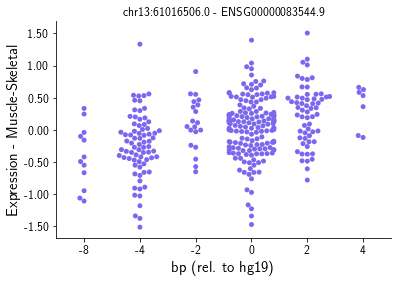

ENSG00000213398.3,16,68014740.0,WholeBlood AAATG 0.937758


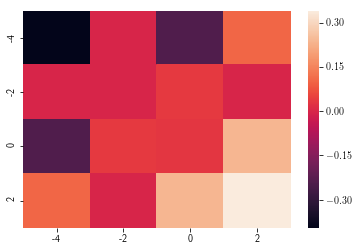

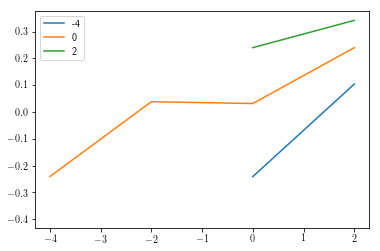

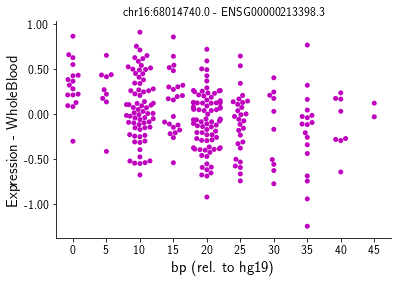

ENSG00000168528.7,1,31886001.0,Artery-Tibial CCCCGG 0.936711


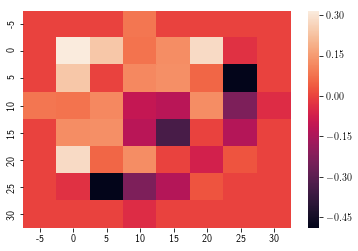

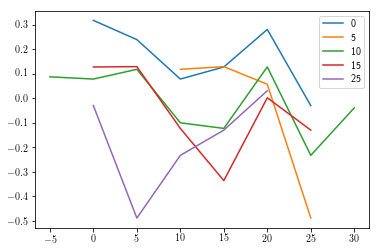

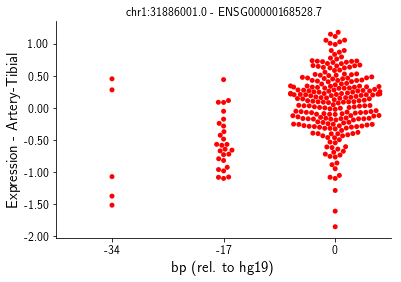

ENSG00000129534.9,14,45692270.0,Nerve-Tibial AAAAC 0.936394


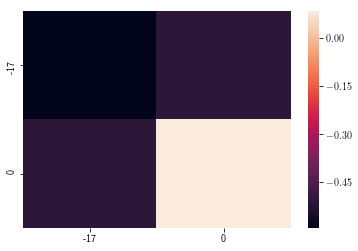

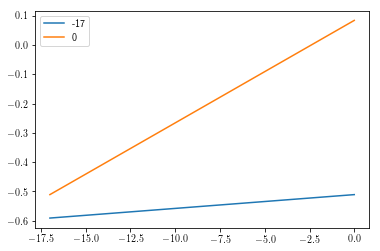

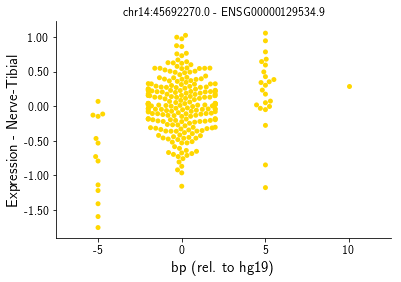

ENSG00000103148.11,16,186525.0,Esophagus-Muscularis A 0.936117


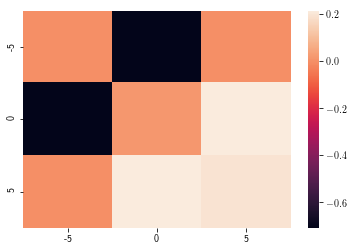

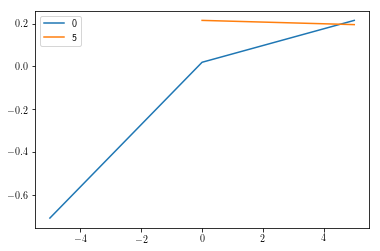

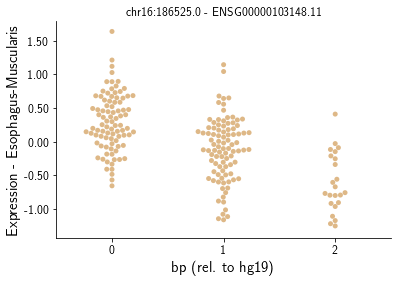

ENSG00000146282.13,6,88203181.0,Skin-SunExposed AC 0.935036


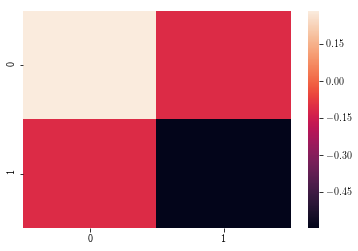

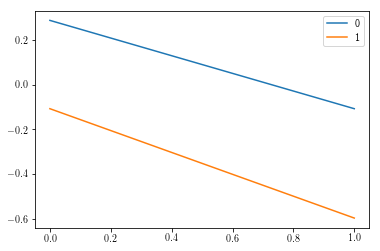

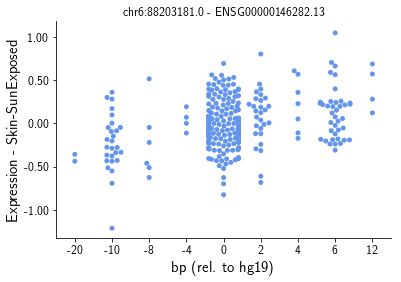

ENSG00000106524.4,7,16696170.0,Nerve-Tibial AC 0.931706


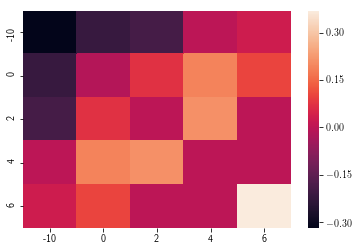

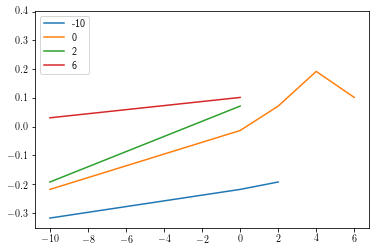

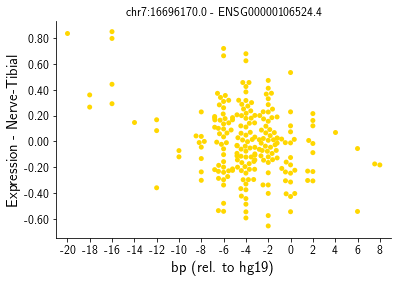

ENSG00000164253.8,5,76879015.0,Cells-Transformedfibroblasts A 0.929459


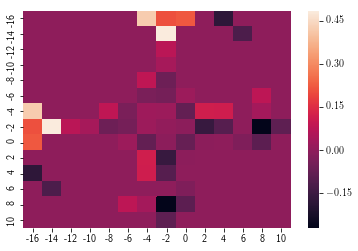

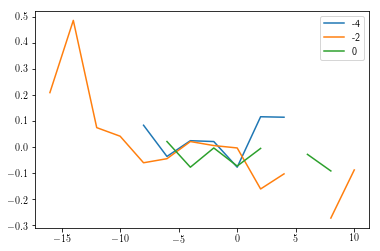

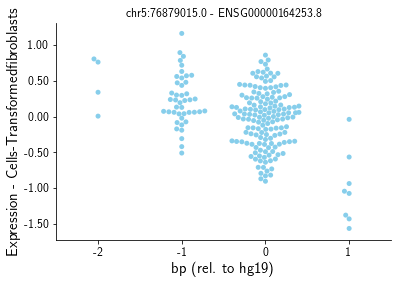

ENSG00000198892.6,1,201841735.0,Thyroid AAC 0.923546


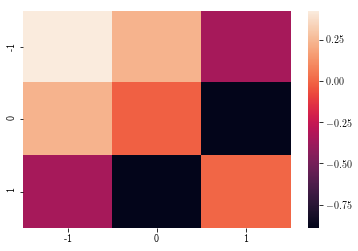

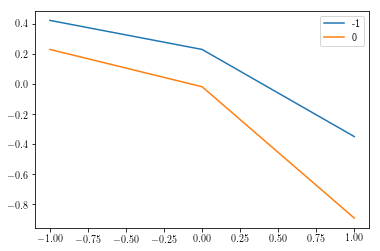

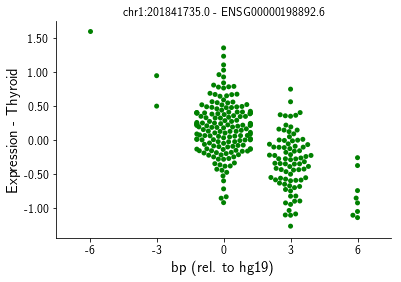

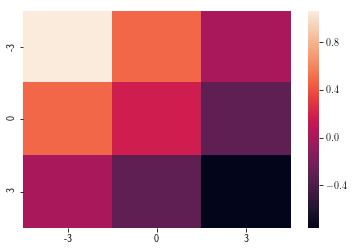

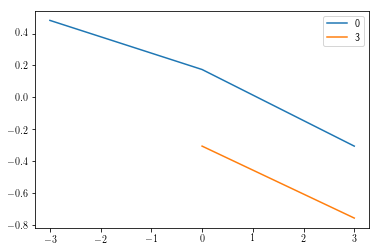

In [27]:
for i in range(len(GENES)):
    print("%s,%s,%s,%s %s %s"%(GENES[i], CHROMS[i], STARTS[i], TISSUES[i], MOTIFS[i], SCORES[i]))
    ExtractData(GENES[i], CHROMS[i].replace("chr",""), STARTS[i], TISSUES[i])
    PlotESTR(GENES[i], TISSUES[i], CHROMS[i].replace("chr",""), STARTS[i], COLORS)
    PlotHeatmap()